In [ ]:
"""
Healthcare Cost Prediction using Deep Learning
Based on: "Deep learning for prediction of population health costs"
BMC Medical Informatics and Decision Making (2022)

Modular implementation with proper error handling
"""

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr, pearsonr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
import warnings
import logging
from typing import Dict, List, Tuple, Optional
import pickle

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# ============================================================================
# DATA LOADING FUNCTIONS
# ============================================================================

def load_claims_data(filepath: str, encoding: str = 'utf-8') -> pd.DataFrame:
    """
    Load claims data from CSV file
    
    Args:
        filepath: Path to CSV file
        encoding: File encoding
        
    Returns:
        DataFrame with claims data
        
    Raises:
        FileNotFoundError: If file doesn't exist
        pd.errors.EmptyDataError: If file is empty
    """
    try:
        logging.info(f"Loading data from {filepath}...")
        df = pd.read_csv(filepath, encoding=encoding)
        
        if df.empty:
            raise pd.errors.EmptyDataError("Loaded DataFrame is empty")
        
        logging.info(f"Successfully loaded {len(df)} records")
        return df
        
    except FileNotFoundError:
        logging.error(f"File not found: {filepath}")
        raise
    except pd.errors.EmptyDataError as e:
        logging.error(f"Empty data file: {e}")
        raise
    except Exception as e:
        logging.error(f"Error loading data: {e}")
        raise


def validate_data_schema(df: pd.DataFrame, required_columns: List[str]) -> bool:
    """
    Validate that DataFrame has required columns
    
    Args:
        df: Input DataFrame
        required_columns: List of required column names
        
    Returns:
        True if valid
        
    Raises:
        ValueError: If required columns are missing
    """
    try:
        missing_cols = [col for col in required_columns if col not in df.columns]
        
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
        
        logging.info("Data schema validation passed")
        return True
        
    except ValueError as e:
        logging.error(f"Schema validation failed: {e}")
        raise


def check_data_quality(df: pd.DataFrame, 
                       numeric_cols: List[str],
                       categorical_cols: List[str]) -> Dict:
    """
    Check data quality and return statistics
    
    Args:
        df: Input DataFrame
        numeric_cols: List of numeric column names
        categorical_cols: List of categorical column names
        
    Returns:
        Dictionary with quality metrics
    """
    try:
        quality_report = {
            'total_rows': len(df),
            'missing_values': {},
            'duplicate_rows': df.duplicated().sum(),
            'numeric_stats': {},
            'categorical_stats': {}
        }
        
        # Check missing values
        for col in df.columns:
            missing = df[col].isnull().sum()
            if missing > 0:
                quality_report['missing_values'][col] = {
                    'count': missing,
                    'percentage': (missing / len(df)) * 100
                }
        
        # Numeric column statistics
        for col in numeric_cols:
            if col in df.columns:
                quality_report['numeric_stats'][col] = {
                    'mean': df[col].mean(),
                    'std': df[col].std(),
                    'min': df[col].min(),
                    'max': df[col].max(),
                    'zeros': (df[col] == 0).sum()
                }
        
        # Categorical column statistics
        for col in categorical_cols:
            if col in df.columns:
                quality_report['categorical_stats'][col] = {
                    'unique_values': df[col].nunique(),
                    'most_common': df[col].value_counts().head(5).to_dict()
                }
        
        logging.info("Data quality check completed")
        return quality_report
        
    except Exception as e:
        logging.error(f"Error in data quality check: {e}")
        raise


# ============================================================================
# DATA PREPROCESSING FUNCTIONS
# ============================================================================

def create_quarter_column(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
    """
    Create quarter column from date column
    
    Args:
        df: Input DataFrame
        date_col: Name of date column
        
    Returns:
        DataFrame with Quarter column added
    """
    try:
        df_copy = df.copy()
        df_copy['Quarter'] = pd.to_datetime(df_copy[date_col]).dt.to_period('Q')
        logging.info(f"Created quarter column from {date_col}")
        return df_copy
        
    except Exception as e:
        logging.error(f"Error creating quarter column: {e}")
        raise


def filter_rare_categories(df: pd.DataFrame, 
                          categorical_cols: List[str],
                          min_frequency: int = 1000) -> pd.DataFrame:
    """
    Filter out rare categories (as per paper - keep only codes with >1000 entries)
    
    Args:
        df: Input DataFrame
        categorical_cols: Columns to filter
        min_frequency: Minimum frequency threshold
        
    Returns:
        Filtered DataFrame
    """
    try:
        df_filtered = df.copy()
        
        for col in categorical_cols:
            if col not in df.columns:
                continue
                
            value_counts = df[col].value_counts()
            valid_categories = value_counts[value_counts >= min_frequency].index
            
            original_unique = df[col].nunique()
            df_filtered = df_filtered[df_filtered[col].isin(valid_categories)]
            filtered_unique = df_filtered[col].nunique()
            
            logging.info(f"Column '{col}': {original_unique} → {filtered_unique} categories")
        
        logging.info(f"Filtered data: {len(df)} → {len(df_filtered)} records")
        return df_filtered
        
    except Exception as e:
        logging.error(f"Error filtering rare categories: {e}")
        raise


def fit_one_hot_encoders(df: pd.DataFrame, 
                         categorical_cols: List[str]) -> Dict[str, OneHotEncoder]:
    """
    Fit one-hot encoders for categorical columns
    
    Args:
        df: Input DataFrame
        categorical_cols: List of categorical columns
        
    Returns:
        Dictionary mapping column names to fitted encoders
    """
    try:
        encoders = {}
        
        for col in categorical_cols:
            if col not in df.columns:
                logging.warning(f"Column '{col}' not found in DataFrame")
                continue
            
            encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            encoder.fit(df[[col]])
            encoders[col] = encoder
            
            n_categories = len(encoder.categories_[0])
            logging.info(f"Fitted encoder for '{col}': {n_categories} categories")
        
        return encoders
        
    except Exception as e:
        logging.error(f"Error fitting encoders: {e}")
        raise


def encode_categorical_features(data: pd.DataFrame,
                                col: str,
                                encoder: OneHotEncoder) -> np.ndarray:
    """
    Encode categorical features and sum if multiple entries
    
    Args:
        data: DataFrame with data for one patient-quarter
        col: Column name to encode
        encoder: Fitted OneHotEncoder
        
    Returns:
        Encoded vector (summed if multiple entries)
    """
    try:
        if len(data) == 0 or col not in data.columns:
            n_categories = len(encoder.categories_[0])
            return np.zeros(n_categories)
        
        encoded = encoder.transform(data[[col]])
        summed = encoded.sum(axis=0)
        return summed
        
    except Exception as e:
        logging.error(f"Error encoding features for column {col}: {e}")
        raise


def aggregate_numerical_features(data: pd.DataFrame,
                                 numerical_cols: List[str],
                                 aggregation: str = 'sum') -> np.ndarray:
    """
    Aggregate numerical features for a quarter
    
    Args:
        data: DataFrame with data for one patient-quarter
        numerical_cols: List of numerical columns
        aggregation: 'sum' or 'mean'
        
    Returns:
        Array of aggregated values
    """
    try:
        result = []
        
        for col in numerical_cols:
            if len(data) == 0 or col not in data.columns:
                result.append(0.0)
            else:
                if aggregation == 'sum':
                    result.append(data[col].sum())
                elif aggregation == 'mean':
                    result.append(data[col].mean())
                else:
                    raise ValueError(f"Unknown aggregation: {aggregation}")
        
        return np.array(result)
        
    except Exception as e:
        logging.error(f"Error aggregating numerical features: {e}")
        raise


def create_patient_vector(patient_data: pd.DataFrame,
                         patient_id: str,
                         n_quarters: int,
                         categorical_cols: List[str],
                         numerical_cols: List[str],
                         encoders: Dict[str, OneHotEncoder],
                         quarter_col: str = 'Quarter') -> Tuple[np.ndarray, List[str]]:
    """
    Create feature vector for a single patient across all quarters (PAPER'S CORE METHOD)
    
    Args:
        patient_data: DataFrame with all data for one patient
        patient_id: Patient identifier
        n_quarters: Number of quarters to include
        categorical_cols: List of categorical columns
        numerical_cols: List of numerical columns
        encoders: Dictionary of fitted encoders
        quarter_col: Name of quarter column
        
    Returns:
        Tuple of (feature_vector, quarter_labels)
    """
    try:
        unique_quarters = sorted(patient_data[quarter_col].unique())
        
        # Limit to n_quarters most recent
        if len(unique_quarters) > n_quarters:
            unique_quarters = unique_quarters[-n_quarters:]
        
        quarterly_vectors = []
        
        for quarter in unique_quarters:
            quarter_data = patient_data[patient_data[quarter_col] == quarter]
            quarter_vector = []
            
            # Encode categorical features
            for col in categorical_cols:
                if col in encoders:
                    encoded = encode_categorical_features(quarter_data, col, encoders[col])
                    quarter_vector.extend(encoded)
            
            # Aggregate numerical features
            numerical = aggregate_numerical_features(quarter_data, numerical_cols)
            quarter_vector.extend(numerical)
            
            quarterly_vectors.extend(quarter_vector)
        
        # Pad with zeros if fewer than n_quarters
        quarter_vector_length = len(quarter_vector) if len(quarterly_vectors) > 0 else 0
        while len(quarterly_vectors) < n_quarters * quarter_vector_length:
            quarterly_vectors.extend([0] * quarter_vector_length)
        
        return np.array(quarterly_vectors), [str(q) for q in unique_quarters]
        
    except Exception as e:
        logging.error(f"Error creating vector for patient {patient_id}: {e}")
        raise


def create_feature_matrix(df: pd.DataFrame,
                         patient_id_col: str,
                         n_quarters: int,
                         categorical_cols: List[str],
                         numerical_cols: List[str],
                         encoders: Dict[str, OneHotEncoder],
                         target_col: str = 'Claim Amount') -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Create feature matrix for all patients (MAIN DATA TRANSFORMATION)
    
    Args:
        df: Input DataFrame with all data
        patient_id_col: Name of patient ID column
        n_quarters: Number of quarters per patient
        categorical_cols: List of categorical columns
        numerical_cols: List of numerical columns
        encoders: Dictionary of fitted encoders
        target_col: Target variable column
        
    Returns:
        Tuple of (X, y, patient_ids)
    """
    try:
        patient_vectors = []
        target_values = []
        patient_ids = []
        
        unique_patients = df[patient_id_col].unique()
        logging.info(f"Processing {len(unique_patients)} patients...")
        
        for i, patient_id in enumerate(unique_patients):
            if (i + 1) % 100 == 0:
                logging.info(f"Processed {i + 1}/{len(unique_patients)} patients")
            
            patient_data = df[df[patient_id_col] == patient_id]
            
            try:
                vector, quarters = create_patient_vector(
                    patient_data, patient_id, n_quarters,
                    categorical_cols, numerical_cols, encoders
                )
                
                # Target: sum of future costs (or could be specific future period)
                target = patient_data[target_col].sum()
                
                patient_vectors.append(vector)
                target_values.append(target)
                patient_ids.append(patient_id)
                
            except Exception as e:
                logging.warning(f"Skipping patient {patient_id}: {e}")
                continue
        
        X = np.array(patient_vectors)
        y = np.array(target_values)
        
        logging.info(f"Created feature matrix: X shape = {X.shape}, y shape = {y.shape}")
        
        return X, y, patient_ids
        
    except Exception as e:
        logging.error(f"Error creating feature matrix: {e}")
        raise


# ============================================================================
# DEEP NEURAL NETWORK FUNCTIONS
# ============================================================================

def build_deep_network(input_dim: int,
                      hidden_layers: int = 4,
                      neurons_per_layer: int = 50,
                      dropout_rate: float = 0.25,
                      output_dim: int = 1) -> keras.Model:
    """
    Build deep neural network (PAPER'S ARCHITECTURE)
    
    Args:
        input_dim: Input feature dimension
        hidden_layers: Number of hidden layers (paper: 4)
        neurons_per_layer: Neurons per hidden layer (paper: 50)
        dropout_rate: Dropout rate (paper: 0.25)
        output_dim: Output dimension (1 for total cost, 7 for categories)
        
    Returns:
        Compiled Keras model
    """
    try:
        logging.info("Building deep neural network...")
        
        # Input layer
        input_layer = layers.Input(shape=(input_dim,), name='input')
        
        # Hidden layers
        x = input_layer
        for i in range(hidden_layers):
            x = layers.Dense(
                neurons_per_layer,
                activation='relu',
                name=f'hidden_{i+1}'
            )(x)
            x = layers.Dropout(dropout_rate, name=f'dropout_{i+1}')(x)
        
        # Skip connection: concatenate original input to last hidden layer
        x = layers.Concatenate(name='skip_connection')([x, input_layer])
        
        # Output layer
        output = layers.Dense(output_dim, activation='linear', name='output')(x)
        
        # Create model
        model = models.Model(inputs=input_layer, outputs=output)
        
        # Compile with ADAM optimizer (paper settings)
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
            loss='mse',
            metrics=['mae']
        )
        
        logging.info(f"Model built successfully")
        logging.info(f"Total parameters: {model.count_params()}")
        
        return model
        
    except Exception as e:
        logging.error(f"Error building model: {e}")
        raise


def create_callbacks(model_path: str = 'best_model.keras',
                    patience: int = 5) -> List[callbacks.Callback]:
    """
    Create training callbacks
    
    Args:
        model_path: Path to save best model
        patience: Patience for early stopping
        
    Returns:
        List of callbacks
    """
    try:
        callback_list = [
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=patience,
                restore_best_weights=True,
                verbose=1
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=0.00001,
                verbose=1
            ),
            callbacks.ModelCheckpoint(
                model_path,
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            )
        ]
        
        return callback_list
        
    except Exception as e:
        logging.error(f"Error creating callbacks: {e}")
        raise


def train_deep_network(model: keras.Model,
                      X_train: np.ndarray,
                      y_train: np.ndarray,
                      X_val: np.ndarray,
                      y_val: np.ndarray,
                      epochs: int = 25,
                      batch_size: int = 32,
                      callbacks_list: Optional[List] = None) -> keras.callbacks.History:
    """
    Train deep neural network (PAPER'S TRAINING PROTOCOL)
    
    Args:
        model: Compiled Keras model
        X_train: Training features
        y_train: Training targets
        X_val: Validation features
        y_val: Validation targets
        epochs: Number of epochs (paper: 25)
        batch_size: Batch size (paper: 32)
        callbacks_list: List of callbacks
        
    Returns:
        Training history
    """
    try:
        logging.info("Training deep neural network...")
        logging.info(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")
        logging.info(f"Epochs: {epochs}, Batch size: {batch_size}")
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list,
            verbose=1
        )
        
        logging.info("Training completed successfully")
        return history
        
    except Exception as e:
        logging.error(f"Error during training: {e}")
        raise


def predict_with_model(model: keras.Model,
                      X: np.ndarray,
                      batch_size: int = 32) -> np.ndarray:
    """
    Make predictions with trained model
    
    Args:
        model: Trained Keras model
        X: Input features
        batch_size: Batch size for prediction
        
    Returns:
        Predictions array
    """
    try:
        predictions = model.predict(X, batch_size=batch_size, verbose=0)
        return predictions.flatten()
        
    except Exception as e:
        logging.error(f"Error making predictions: {e}")
        raise


# ============================================================================
# RIDGE REGRESSION BASELINE FUNCTIONS
# ============================================================================

def train_ridge_regression(X_train: np.ndarray,
                          y_train: np.ndarray,
                          alpha: float = 0.1) -> Ridge:
    """
    Train Ridge regression baseline (PAPER'S BASELINE)
    
    Args:
        X_train: Training features
        y_train: Training targets
        alpha: Regularization parameter (paper: 0.1)
        
    Returns:
        Trained Ridge model
    """
    try:
        logging.info(f"Training Ridge regression with alpha={alpha}...")
        
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)
        
        logging.info("Ridge regression training completed")
        return model
        
    except Exception as e:
        logging.error(f"Error training Ridge regression: {e}")
        raise


def predict_ridge(model: Ridge, X: np.ndarray) -> np.ndarray:
    """
    Make predictions with Ridge regression
    
    Args:
        model: Trained Ridge model
        X: Input features
        
    Returns:
        Predictions array
    """
    try:
        predictions = model.predict(X)
        return predictions
        
    except Exception as e:
        logging.error(f"Error making Ridge predictions: {e}")
        raise



# ==========================================
# 1. RANDOM FOREST
# ==========================================
import numpy as np
import logging
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

def train_random_forest(X_train: np.ndarray, 
                        y_train: np.ndarray, 
                        n_estimators: int = 100,
                        max_depth: int = None,
                        random_state: int = 42) -> RandomForestRegressor:
    """
    Train Random Forest Regressor
    
    Args:
        X_train: Training features
        y_train: Training targets
        n_estimators: Number of trees in the forest
        max_depth: Maximum depth of the tree
        random_state: Seed for reproducibility
        
    Returns:
        Trained Random Forest model
    """
    try:
        logging.info(f"Training Random Forest with n_estimators={n_estimators}, max_depth={max_depth}...")
        
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=random_state,
            n_jobs=-1  # Use all available cores
        )
        model.fit(X_train, y_train)
        
        logging.info("Random Forest training completed")
        return model
        
    except Exception as e:
        logging.error(f"Error training Random Forest: {e}")
        raise


def predict_random_forest(model: RandomForestRegressor, X: np.ndarray) -> np.ndarray:
    """
    Make predictions with Random Forest
    
    Args:
        model: Trained Random Forest model
        X: Input features
        
    Returns:
        Predictions array
    """
    try:
        predictions = model.predict(X)
        return predictions
        
    except Exception as e:
        logging.error(f"Error making Random Forest predictions: {e}")
        raise


# ==========================================
# 2. XGBOOST
# ==========================================

def train_xgboost(X_train: np.ndarray, 
                  y_train: np.ndarray, 
                  learning_rate: float = 0.1,
                  n_estimators: int = 100,
                  max_depth: int = 3) -> XGBRegressor:
    """
    Train XGBoost Regressor
    
    Args:
        X_train: Training features
        y_train: Training targets
        learning_rate: Step size shrinkage used in update to prevent overfitting
        n_estimators: Number of boosting rounds
        max_depth: Maximum depth of a tree
        
    Returns:
        Trained XGBoost model
    """
    try:
        logging.info(f"Training XGBoost with lr={learning_rate}, n_estimators={n_estimators}...")
        
        model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        
        logging.info("XGBoost training completed")
        return model
        
    except Exception as e:
        logging.error(f"Error training XGBoost: {e}")
        raise


def predict_xgboost(model: XGBRegressor, X: np.ndarray) -> np.ndarray:
    """
    Make predictions with XGBoost
    
    Args:
        model: Trained XGBoost model
        X: Input features
        
    Returns:
        Predictions array
    """
    try:
        predictions = model.predict(X)
        return predictions
        
    except Exception as e:
        logging.error(f"Error making XGBoost predictions: {e}")
        raise


# ==========================================
# 3. LIGHTGBM
# ==========================================

def train_lightgbm(X_train: np.ndarray, 
                   y_train: np.ndarray, 
                   learning_rate: float = 0.1,
                   n_estimators: int = 100,
                   num_leaves: int = 31) -> LGBMRegressor:
    """
    Train LightGBM Regressor
    
    Args:
        X_train: Training features
        y_train: Training targets
        learning_rate: Boosting learning rate
        n_estimators: Number of boosted trees to fit
        num_leaves: Max number of leaves in one tree
        
    Returns:
        Trained LightGBM model
    """
    try:
        logging.info(f"Training LightGBM with lr={learning_rate}, n_estimators={n_estimators}...")
        
        model = LGBMRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            random_state=42,
            n_jobs=-1,
            verbose=-1 # Suppress internal LightGBM warnings
        )
        model.fit(X_train, y_train)
        
        logging.info("LightGBM training completed")
        return model
        
    except Exception as e:
        logging.error(f"Error training LightGBM: {e}")
        raise


def predict_lightgbm(model: LGBMRegressor, X: np.ndarray) -> np.ndarray:
    """
    Make predictions with LightGBM
    
    Args:
        model: Trained LightGBM model
        X: Input features
        
    Returns:
        Predictions array
    """
    try:
        predictions = model.predict(X)
        return predictions
        
    except Exception as e:
        logging.error(f"Error making LightGBM predictions: {e}")
        raise


# ============================================================================
# EVALUATION FUNCTIONS
# ============================================================================

def calculate_metrics(y_true: np.ndarray,
                     y_pred: np.ndarray) -> Dict[str, float]:
    """
    Calculate evaluation metrics (PAPER'S METRICS)
    
    Args:
        y_true: True values
        y_pred: Predicted values
        
    Returns:
        Dictionary with metrics
    """
    try:
        metrics = {}
        
        # Mean Absolute Error
        metrics['MAE'] = mean_absolute_error(y_true, y_pred)
        
        # R² Score
        metrics['R2'] = r2_score(y_true, y_pred)
        
        # Pearson Correlation
        pearson_corr, _ = pearsonr(y_true, y_pred)
        metrics['Pearson_Correlation'] = pearson_corr
        
        # Spearman Correlation
        spearman_corr, _ = spearmanr(y_true, y_pred)
        metrics['Spearman_Correlation'] = spearman_corr
        
        # Root Mean Squared Error
        metrics['RMSE'] = np.sqrt(np.mean((y_true - y_pred) ** 2))
        
        # Mean Absolute Percentage Error
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
        metrics['MAPE'] = mape
        
        return metrics
        
    except Exception as e:
        logging.error(f"Error calculating metrics: {e}")
        raise


def evaluate_model(y_true: np.ndarray,
                   y_pred: np.ndarray,
                   model_name: str = "Model") -> Dict[str, float]:
    """
    Evaluate model and print results
    
    Args:
        y_true: True values
        y_pred: Predicted values
        model_name: Name of the model
        
    Returns:
        Dictionary with metrics
    """
    try:
        logging.info(f"Evaluating {model_name}...")
        
        metrics = calculate_metrics(y_true, y_pred)
        
        print(f"\n{'='*60}")
        print(f"{model_name} EVALUATION RESULTS")
        print(f"{'='*60}")
        for metric_name, value in metrics.items():
            print(f"{metric_name:25s}: {value:.4f}")
        print(f"{'='*60}\n")
        
        return metrics
        
    except Exception as e:
        logging.error(f"Error in model evaluation: {e}")
        raise


def compare_models(metrics_dict: Dict[str, Dict[str, float]]) -> pd.DataFrame:
    """
    Compare multiple models
    
    Args:
        metrics_dict: Dictionary mapping model names to their metrics
        
    Returns:
        DataFrame with comparison
    """
    try:
        df_comparison = pd.DataFrame(metrics_dict).T
        
        print(f"\n{'='*80}")
        print("MODEL COMPARISON")
        print(f"{'='*80}")
        print(df_comparison.to_string())
        print(f"{'='*80}\n")
        
        # Determine winners
        for metric in df_comparison.columns:
            if metric == 'MAE' or metric == 'RMSE' or metric == 'MAPE':
                winner = df_comparison[metric].idxmin()
            else:
                winner = df_comparison[metric].idxmax()
            print(f"Best {metric:25s}: {winner}")
        
        return df_comparison
        
    except Exception as e:
        logging.error(f"Error comparing models: {e}")
        raise


def analyze_predictions_by_cost_range(y_true: np.ndarray,
                                     y_pred: np.ndarray,
                                     ranges: List[Tuple[float, float]] = None) -> pd.DataFrame:
    """
    Analyze prediction errors by cost ranges (as in paper)
    
    Args:
        y_true: True values
        y_pred: Predicted values
        ranges: List of (min, max) cost ranges
        
    Returns:
        DataFrame with analysis by range
    """
    try:
        if ranges is None:
            ranges = [(0, 1000), (1000, 5000), (5000, 10000), (10000, 50000), (50000, np.inf)]
        
        results = []
        
        for min_cost, max_cost in ranges:
            mask = (y_true >= min_cost) & (y_true < max_cost)
            
            if mask.sum() == 0:
                continue
            
            range_true = y_true[mask]
            range_pred = y_pred[mask]
            
            results.append({
                'Cost_Range': f"{min_cost}-{max_cost if max_cost != np.inf else 'inf'}",
                'N_Samples': mask.sum(),
                'MAE': mean_absolute_error(range_true, range_pred),
                'RMSE': np.sqrt(np.mean((range_true - range_pred) ** 2)),
                'R2': r2_score(range_true, range_pred) if mask.sum() > 1 else np.nan
            })
        
        df_results = pd.DataFrame(results)
        
        print(f"\n{'='*80}")
        print("PREDICTION ANALYSIS BY COST RANGE")
        print(f"{'='*80}")
        print(df_results.to_string(index=False))
        print(f"{'='*80}\n")
        
        return df_results
        
    except Exception as e:
        logging.error(f"Error analyzing by cost range: {e}")
        raise


# ============================================================================
# MODEL SAVING/LOADING FUNCTIONS
# ============================================================================

def save_encoders(encoders: Dict[str, OneHotEncoder], filepath: str):
    """Save fitted encoders"""
    try:
        with open(filepath, 'wb') as f:
            pickle.dump(encoders, f)
        logging.info(f"Encoders saved to {filepath}")
    except Exception as e:
        logging.error(f"Error saving encoders: {e}")
        raise


def load_encoders(filepath: str) -> Dict[str, OneHotEncoder]:
    """Load fitted encoders"""
    try:
        with open(filepath, 'rb') as f:
            encoders = pickle.load(f)
        logging.info(f"Encoders loaded from {filepath}")
        return encoders
    except Exception as e:
        logging.error(f"Error loading encoders: {e}")
        raise


def save_model(model: keras.Model, filepath: str):
    """Save Keras model"""
    try:
        model.save(filepath)
        logging.info(f"Model saved to {filepath}")
    except Exception as e:
        logging.error(f"Error saving model: {e}")
        raise


def load_model(filepath: str) -> keras.Model:
    """Load Keras model"""
    try:
        model = keras.models.load_model(filepath)
        logging.info(f"Model loaded from {filepath}")
        return model
    except Exception as e:
        logging.error(f"Error loading model: {e}")
        raise


# ============================================================================
# EXAMPLE USAGE
# ============================================================================


In [41]:
df = load_claims_data('Fianl_claims_data.csv')

2025-11-22 11:00:05,320 - INFO - Loading data from Fianl_claims_data.csv...
2025-11-22 11:00:06,003 - INFO - Successfully loaded 116437 records


In [59]:
df.sample(2)

,Claimant Unique ID,Unique Member Reference,Claim ID,Incurred Date,Paid Date,Condition Code,Impairment Code,Condition Category,Treatment Type,Claim Type,Ancillary Service Type,Treatment Location,Provider Type,Admission Date,Discharge Date,Calculate Length of Service,Claim Amount,Amount Paid,Industry,Client Name,Client Identifier,Scheme Category/ Section Name,Scheme Category/ Section Name Identifier,Status of Member,Year of Birth,Gender,Short Post Code,Contract Start Date,Contract End Date,Age,Quarter
6823,EMP00000600-02,EMP00000600,CLM00052899,17/10/2022,01/11/2022,I25.1,IMP-CVD-587,Cardiovascular,Diagnostic,Inpatient,NaN,Wales,Hospital,17/10/2022,25/10/2022,8,24911.57,24827.33,Chemical,Victrex plc,CLI000014,Comprehensive Cover,SCH0009,Dependent,1963,Female,EC1A,14-05-2020,24-12-2022,59,2022Q4
97705,EMP00008281-01,EMP00008281,CLM00093037,01/05/2019,08/05/2019,K21.0,IMP-DIG-479,Digestive,Medical,Cash Benefit,NaN,England,Hospital,NaN,NaN,0,1600.19,1495.46,IT,IBM UK,CLI000002,Standard Plan,SCH0006,Member,1974,Female,CF11,02-08-2018,19-08-2019,45,2019Q2


In [42]:

required_cols = df.columns#['Claimant Unique ID', 'Paid Date', 'Condition (Impairment Code)', ...]
validate_data_schema(df, required_cols)

2025-11-22 11:00:08,405 - INFO - Data schema validation passed


True

In [43]:
df.columns

Index(['Claimant Unique ID', 'Unique Member Reference', 'Claim ID',
       'Incurred Date', 'Paid Date', 'Condition Code', 'Impairment Code',
       'Condition Category', 'Treatment Type', 'Claim Type',
       'Ancillary Service Type', 'Treatment Location', 'Provider Type',
       'Admission Date', 'Discharge Date', 'Calculate Length of Service',
       'Claim Amount', 'Amount Paid', 'Industry', 'Client Name',
       'Client Identifier', 'Scheme Category/ Section Name',
       'Scheme Category/ Section Name Identifier', 'Status of Member',
       'Year of Birth', 'Gender', 'Short Post Code', 'Contract Start Date',
       'Contract End Date', 'Age'],
      dtype='object')

In [44]:

quality = check_data_quality(df, numeric_cols=['Calculate Length of Service',
       'Claim Amount', 'Amount Paid','Age'], 
                                 categorical_cols=['Condition Code', 'Impairment Code',
       'Condition Category', 'Treatment Type', 'Claim Type',
       'Ancillary Service Type', 'Treatment Location', 'Provider Type','Industry', 'Client Name',
       'Client Identifier', 'Scheme Category/ Section Name',
       'Scheme Category/ Section Name Identifier', 'Status of Member','Short Post Code'])

2025-11-22 11:00:15,324 - INFO - Data quality check completed


In [45]:
df = create_quarter_column(df, 'Incurred Date')

2025-11-22 11:00:17,422 - INFO - Created quarter column from Incurred Date


In [46]:
categorical_cols=['Condition Code', 'Impairment Code',
       'Condition Category', 'Treatment Type', 'Claim Type',
       'Ancillary Service Type', 'Treatment Location', 'Provider Type','Industry', 'Client Name',
       'Client Identifier', 'Scheme Category/ Section Name',
       'Scheme Category/ Section Name Identifier', 'Status of Member','Short Post Code']
df_filtered = filter_rare_categories(df, categorical_cols, min_frequency=25)

2025-11-22 11:00:19,722 - INFO - Column 'Condition Code': 79 → 76 categories
2025-11-22 11:00:19,784 - INFO - Column 'Impairment Code': 11315 → 680 categories
2025-11-22 11:00:19,808 - INFO - Column 'Condition Category': 19 → 8 categories
2025-11-22 11:00:19,841 - INFO - Column 'Treatment Type': 4 → 4 categories
2025-11-22 11:00:19,872 - INFO - Column 'Claim Type': 4 → 4 categories
2025-11-22 11:00:19,888 - INFO - Column 'Ancillary Service Type': 9 → 7 categories
2025-11-22 11:00:19,906 - INFO - Column 'Treatment Location': 4 → 4 categories
2025-11-22 11:00:19,938 - INFO - Column 'Provider Type': 4 → 4 categories
2025-11-22 11:00:19,979 - INFO - Column 'Industry': 5 → 5 categories
2025-11-22 11:00:20,006 - INFO - Column 'Client Name': 25 → 25 categories
2025-11-22 11:00:20,047 - INFO - Column 'Client Identifier': 25 → 25 categories
2025-11-22 11:00:20,069 - INFO - Column 'Scheme Category/ Section Name': 12 → 12 categories
2025-11-22 11:00:20,092 - INFO - Column 'Scheme Category/ Sectio

In [47]:
encoders = fit_one_hot_encoders(df_filtered, categorical_cols)

2025-11-22 11:00:22,940 - INFO - Fitted encoder for 'Condition Code': 33 categories
2025-11-22 11:00:22,947 - INFO - Fitted encoder for 'Impairment Code': 680 categories
2025-11-22 11:00:22,951 - INFO - Fitted encoder for 'Condition Category': 8 categories
2025-11-22 11:00:22,955 - INFO - Fitted encoder for 'Treatment Type': 4 categories
2025-11-22 11:00:22,959 - INFO - Fitted encoder for 'Claim Type': 4 categories
2025-11-22 11:00:22,965 - INFO - Fitted encoder for 'Ancillary Service Type': 7 categories
2025-11-22 11:00:22,969 - INFO - Fitted encoder for 'Treatment Location': 4 categories
2025-11-22 11:00:22,975 - INFO - Fitted encoder for 'Provider Type': 4 categories
2025-11-22 11:00:22,979 - INFO - Fitted encoder for 'Industry': 5 categories
2025-11-22 11:00:22,986 - INFO - Fitted encoder for 'Client Name': 25 categories
2025-11-22 11:00:22,986 - INFO - Fitted encoder for 'Client Identifier': 25 categories
2025-11-22 11:00:22,991 - INFO - Fitted encoder for 'Scheme Category/ Sectio

In [48]:
numeric_cols=['Calculate Length of Service',
       'Claim Amount', 'Amount Paid','Age']

X, y, patient_ids = create_feature_matrix(df_filtered, 'Claimant Unique ID',8,categorical_cols, numeric_cols, encoders,)

2025-11-22 11:00:25,498 - INFO - Processing 2785 patients...
2025-11-22 11:00:28,432 - INFO - Processed 100/2785 patients
2025-11-22 11:00:31,013 - INFO - Processed 200/2785 patients
2025-11-22 11:00:33,918 - INFO - Processed 300/2785 patients
2025-11-22 11:00:36,405 - INFO - Processed 400/2785 patients
2025-11-22 11:00:39,077 - INFO - Processed 500/2785 patients
2025-11-22 11:00:42,339 - INFO - Processed 600/2785 patients
2025-11-22 11:00:45,074 - INFO - Processed 700/2785 patients
2025-11-22 11:00:47,337 - INFO - Processed 800/2785 patients
2025-11-22 11:00:50,571 - INFO - Processed 900/2785 patients
2025-11-22 11:00:53,254 - INFO - Processed 1000/2785 patients
2025-11-22 11:00:56,332 - INFO - Processed 1100/2785 patients
2025-11-22 11:00:59,198 - INFO - Processed 1200/2785 patients
2025-11-22 11:01:02,039 - INFO - Processed 1300/2785 patients
2025-11-22 11:01:04,412 - INFO - Processed 1400/2785 patients
2025-11-22 11:01:06,911 - INFO - Processed 1500/2785 patients
2025-11-22 11:01:0

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
model = build_deep_network(input_dim=X_train.shape[1]) 
callbacks_list = create_callbacks()
history = train_deep_network(model, X_train, y_train, X_test, y_test,epochs=25, batch_size=32, callbacks_list=callbacks_list)

2025-11-22 11:01:55,489 - INFO - Building deep neural network...
2025-11-22 11:01:55,865 - INFO - Model built successfully
2025-11-22 11:01:55,865 - INFO - Total parameters: 354551
2025-11-22 11:01:55,869 - INFO - Training deep neural network...
2025-11-22 11:01:55,869 - INFO - Training samples: 1949, Validation samples: 836
2025-11-22 11:01:55,873 - INFO - Epochs: 25, Batch size: 32


Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1533254272.0000 - mae: 22960.0352
Epoch 1: val_loss improved from inf to 32126038.00000, saving model to best_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1528967168.0000 - mae: 22903.6602 - val_loss: 32126038.0000 - val_mae: 2658.2795 - learning_rate: 0.0010
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 129546760.0000 - mae: 5915.8613
Epoch 2: val_loss improved from 32126038.00000 to 12806515.00000, saving model to best_model.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 129373464.0000 - mae: 5905.9185 - val_loss: 12806515.0000 - val_mae: 1429.3496 - learning_rate: 0.0010
Epoch 3/25
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 81932208.0000 - mae: 4101.7651 
Epoch 3: val_loss did not improve from 12806515.00000
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 83896256.0000 - mae: 4153.1030 - val_loss: 25225128.0000 - val_mae: 1977.3805 - learning_rate: 0.0010
Epoch 4/25
59/61 ━━━━━━━━━━━━━━━━

2025-11-22 11:02:02,529 - INFO - Training completed successfully


In [51]:
y_pred_dnn = predict_with_model(model, X_test)

In [52]:
metrics_dnn = evaluate_model(y_test, y_pred_dnn, "Deep Neural Network")

2025-11-22 11:02:41,197 - INFO - Evaluating Deep Neural Network...



Deep Neural Network EVALUATION RESULTS
MAE                      : 1429.3497
R2                       : 0.9878
Pearson_Correlation      : 0.9948
Spearman_Correlation     : 0.9988
RMSE                     : 3578.6193
MAPE                     : 7.9334



In [56]:
random_forest_model = train_random_forest(X_train, y_train)
y_predict_random_forest = predict_random_forest(random_forest_model,X_test)
metrics_randomforest = evaluate_model(y_test, y_predict_random_forest, "Random Forest")

2025-11-22 11:07:21,945 - INFO - Training Random Forest with n_estimators=100, max_depth=None...
2025-11-22 11:07:44,736 - INFO - Random Forest training completed
2025-11-22 11:07:44,791 - INFO - Evaluating Random Forest...



Random Forest EVALUATION RESULTS
MAE                      : 2519.4938
R2                       : 0.9300
Pearson_Correlation      : 0.9696
Spearman_Correlation     : 0.9983
RMSE                     : 8572.1272
MAPE                     : 5.3005



In [55]:
xgboost_model = train_xgboost(X_train, y_train)
y_predict_xgboost = predict_xgboost(xgboost_model,X_test)
metrics_xgboost = evaluate_model(y_test, y_predict_xgboost, "Xgboost")

2025-11-22 11:05:15,698 - INFO - Training XGBoost with lr=0.1, n_estimators=100...
2025-11-22 11:05:17,233 - INFO - XGBoost training completed
2025-11-22 11:05:17,260 - INFO - Evaluating Xgboost...



Xgboost EVALUATION RESULTS
MAE                      : 2532.1398
R2                       : 0.9597
Pearson_Correlation      : 0.9804
Spearman_Correlation     : 0.9947
RMSE                     : 6507.4376
MAPE                     : 19.6295



In [58]:
lightgbm_model = train_lightgbm(X_train, y_train)
y_predict_lightgbm = predict_lightgbm(lightgbm_model,X_test)
metrics_lightgbm= evaluate_model(y_test, y_predict_lightgbm, "LightGbm")

2025-11-22 11:08:27,341 - INFO - Training LightGBM with lr=0.1, n_estimators=100...
2025-11-22 11:08:27,646 - INFO - LightGBM training completed
2025-11-22 11:08:27,653 - INFO - Evaluating LightGbm...



LightGbm EVALUATION RESULTS
MAE                      : 2207.2974
R2                       : 0.9576
Pearson_Correlation      : 0.9794
Spearman_Correlation     : 0.9983
RMSE                     : 6673.3235
MAPE                     : 6.5437



In [36]:
ridge_model = train_ridge_regression(X_train, y_train, alpha=0.1)
y_pred_ridge = predict_ridge(ridge_model, X_test)
metrics_ridge = evaluate_model(y_test, y_pred_ridge, "Ridge Regression")

2025-11-21 19:13:05,032 - INFO - Training Ridge regression with alpha=0.1...
2025-11-21 19:13:05,633 - INFO - Ridge regression training completed
2025-11-21 19:13:05,651 - INFO - Evaluating Ridge Regression...



Ridge Regression EVALUATION RESULTS
MAE                      : 533.4552
R2                       : 0.9931
Pearson_Correlation      : 0.9966
Spearman_Correlation     : 0.9996
RMSE                     : 2691.2215
MAPE                     : 1.8186



In [37]:
comparison = compare_models({'Deep_NN': metrics_dnn, 'Ridge': metrics_ridge})


MODEL COMPARISON
            MAE   R2  Pearson_Correlation  Spearman_Correlation    RMSE  MAPE
Deep_NN 1285.37 0.99                 1.00                  1.00 3376.51  4.96
Ridge    533.46 0.99                 1.00                  1.00 2691.22  1.82

Best MAE                      : Ridge
Best R2                       : Ridge
Best Pearson_Correlation      : Deep_NN
Best Spearman_Correlation     : Deep_NN
Best RMSE                     : Ridge
Best MAPE                     : Ridge


In [38]:
analyze_predictions_by_cost_range(y_test, y_pred_dnn)


PREDICTION ANALYSIS BY COST RANGE
 Cost_Range  N_Samples     MAE    RMSE   R2
     0-1000         32   23.35   29.70 0.97
  1000-5000        253  124.85  158.42 0.98
 5000-10000        143  338.31  402.91 0.92
10000-50000        308 1172.59 1577.29 0.98
  50000-inf        100 6326.98 9346.25 0.95



,Cost_Range,N_Samples,MAE,RMSE,R2
0,0-1000,32,23.35,29.70,0.97
1,1000-5000,253,124.85,158.42,0.98
2,5000-10000,143,338.31,402.91,0.92
3,10000-50000,308,1172.59,1577.29,0.98
4,50000-inf,100,6326.98,9346.25,0.95


In [ ]:

if __name__ == "__main__":
    
    # Example: How to use these functions
    
    print("="*80)
    print("HEALTHCARE COST PREDICTION - MODULAR IMPLEMENTATION")
    print("="*80)
    print("\nThis is a modular, function-based implementation.")
    print("Each function handles a specific task with proper error handling.")
    print("\nTo use with your data, follow this workflow:\n")
    
    # 1. Load your data
    df = load_claims_data('Fianl_claims_data.csv')
    
    # 2. Validate schema
    required_cols = df.columns#['Claimant Unique ID', 'Paid Date', 'Condition (Impairment Code)', ...]
    validate_data_schema(df, required_cols)
    
    # 3. Check data quality
    quality = check_data_quality(df, numeric_cols=['Claim Amount'], 
                                 categorical_cols=['Condition (Impairment Code)'])
    
    # 4. Create quarters
    df = create_quarter_column(df, 'Paid Date')
    
    # 5. Filter rare categories (>1000 occurrences as per paper)
    df_filtered = filter_rare_categories(df, categorical_cols, min_frequency=1000)
    
    # 6. Fit encoders
    encoders = fit_one_hot_encoders(df_filtered, categorical_cols)
    
    # 7. Create feature matrix
    X, y, patient_ids = create_feature_matrix(
        df_filtered, 'Claimant Unique ID', n_quarters=8,
        categorical_cols, numerical_cols, encoders
    )
    
    # 8. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # 9. Build and train Deep Neural Network
    model = build_deep_network(input_dim=X_train.shape[1])
    callbacks_list = create_callbacks()
    history = train_deep_network(model, X_train, y_train, X_test, y_test, 
                                 epochs=25, batch_size=32, callbacks_list=callbacks_list)
    
    # 10. Make predictions
    y_pred_dnn = predict_with_model(model, X_test)
    
    # 11. Evaluate
    metrics_dnn = evaluate_model(y_test, y_pred_dnn, "Deep Neural Network")
    
    # 12. Train Ridge baseline
    ridge_model = train_ridge_regression(X_train, y_train, alpha=0.1)
    y_pred_ridge = predict_ridge(ridge_model, X_test)
    metrics_ridge = evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
    
    # 13. Compare models
    comparison = compare_models({'Deep_NN': metrics_dnn, 'Ridge': metrics_ridge})
    
    # 14. Analyze by cost range
    analyze_predictions_by_cost_range(y_test, y_pred_dnn)
    
    # 15. Save models
    save_model(model, 'deep_network.keras')
    save_encoders(encoders, 'encoders.pkl')

    
    print(workflow)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class DiseasePredictionModel:
    """
    Bayesian Network based disease prediction model for UK PMI claims data
    Predicts likelihood of developing Oncology, Cardiovascular, or Mental Health conditions
    """
    
    def __init__(self):
        self.model = GaussianNB()
        self.label_encoders = {}
        self.feature_columns = []
        self.high_risk_conditions = ['Oncology', 'Cardiovascular', 'Mental Health']
        
    def load_data(self, filepath):
        """Load claims data from CSV"""
        print(f"Loading data from {filepath}...")
        df = pd.read_csv(filepath)
        
        # Convert dates
        date_columns = ['Incurred Date', 'Paid Date', 'Contract Start Date', 'Contract End Date']
        for col in date_columns:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
        
        print(f"Loaded {len(df):,} claims for {df['Unique Member Reference'].nunique():,} members")
        return df
    
    def engineer_features(self, claims_df, prediction_date=None):
        """
        Engineer features from claims history for each member
        
        Features include:
        - Demographic: Age, Gender
        - Claim Pattern: Frequency, Trend, Recency
        - Treatment Intensity: Hospitalization rate, Avg claim amount
        - Risk Indicators: Diagnostic tests, Specialist visits
        - Condition History: Prior related conditions
        """
        
        if prediction_date is None:
            prediction_date = claims_df['Incurred Date'].max()
        
        print(f"\nEngineering features up to {prediction_date.strftime('%Y-%m-%d')}...")
        
        # Filter claims before prediction date
        historical_claims = claims_df[claims_df['Incurred Date'] <= prediction_date].copy()
        
        member_features = []
        
        for member_id in historical_claims['Unique Member Reference'].unique():
            member_claims = historical_claims[
                historical_claims['Unique Member Reference'] == member_id
            ].sort_values('Incurred Date')
            
            if len(member_claims) == 0:
                continue
            
            # Get latest member info
            latest_claim = member_claims.iloc[-1]
            
            # Calculate time windows
            last_claim_date = member_claims['Incurred Date'].max()
            lookback_6m = last_claim_date - timedelta(days=180)
            lookback_12m = last_claim_date - timedelta(days=365)
            lookback_24m = last_claim_date - timedelta(days=730)
            
            # Claims in different time windows
            claims_6m = member_claims[member_claims['Incurred Date'] >= lookback_6m]
            claims_12m = member_claims[member_claims['Incurred Date'] >= lookback_12m]
            claims_24m = member_claims[member_claims['Incurred Date'] >= lookback_24m]
            
            # === DEMOGRAPHIC FEATURES ===
            age = latest_claim['Age'] if 'Age' in latest_claim else 40
            gender_encoded = 1 if latest_claim.get('Gender') == 'Male' else 0
            
            # === TEMPORAL FEATURES ===
            claims_count_6m = len(claims_6m)
            claims_count_12m = len(claims_12m)
            claims_count_24m = len(claims_24m)
            
            # Claim frequency trend (increasing = 1, stable = 0, decreasing = -1)
            if claims_count_6m > claims_count_12m * 0.6:
                claim_trend = 1  # Increasing
            elif claims_count_6m < claims_count_12m * 0.3:
                claim_trend = -1  # Decreasing
            else:
                claim_trend = 0  # Stable
            
            # Days since last claim
            days_since_last_claim = (prediction_date - last_claim_date).days
            
            # === TREATMENT INTENSITY FEATURES ===
            total_claim_amount_12m = claims_12m['Claim Amount'].sum()
            avg_claim_amount_12m = claims_12m['Claim Amount'].mean()
            
            # Hospitalization rate
            inpatient_claims = claims_12m[claims_12m['Claim Type'] == 'Inpatient']
            hospitalization_rate = len(inpatient_claims) / len(claims_12m) if len(claims_12m) > 0 else 0
            
            # Average length of stay
            avg_los = claims_12m['Calculate Length of Service'].mean()
            
            # === DIAGNOSTIC & TREATMENT PATTERN FEATURES ===
            diagnostic_claims = claims_12m[claims_12m['Treatment Type'] == 'Diagnostic']
            surgical_claims = claims_12m[claims_12m['Treatment Type'] == 'Surgical']
            
            diagnostic_ratio = len(diagnostic_claims) / len(claims_12m) if len(claims_12m) > 0 else 0
            surgical_ratio = len(surgical_claims) / len(claims_12m) if len(claims_12m) > 0 else 0
            
            # Specialist visits
            hospital_visits = claims_12m[claims_12m['Provider Type'] == 'Hospital']
            specialist_ratio = len(hospital_visits) / len(claims_12m) if len(claims_12m) > 0 else 0
            
            # Diagnostic center visits (imaging/tests)
            diagnostic_center_visits = len(claims_12m[claims_12m['Provider Type'] == 'Diagnostic Center'])
            
            # === ANCILLARY SERVICE FEATURES ===
            ancillary_services = claims_12m['Ancillary Service Type'].dropna().tolist()
            has_imaging = any('Imaging' in str(s) for s in ancillary_services)
            has_pathology = any('Pathology' in str(s) for s in ancillary_services)
            has_therapy = any('Therapy' in str(s) for s in ancillary_services)
            has_chemotherapy = any('Chemotherapy' in str(s) for s in ancillary_services)
            has_radiotherapy = any('Radiotherapy' in str(s) for s in ancillary_services)
            
            # === CONDITION HISTORY FEATURES ===
            all_conditions = member_claims['Condition Category'].unique().tolist()
            
            # Pre-existing condition indicators
            has_musculoskeletal = 'Musculoskeletal' in all_conditions
            has_digestive = 'Digestive' in all_conditions
            has_respiratory = 'Respiratory' in all_conditions
            has_cardiovascular = 'Cardiovascular' in all_conditions
            has_mental_health = 'Mental Health' in all_conditions
            has_oncology = 'Oncology' in all_conditions
            has_endocrine = 'Endocrine' in all_conditions
            has_neurology = 'Neurology' in all_conditions
            
            # Count unique condition categories
            unique_conditions_count = len(all_conditions)
            
            # === RISK INDICATORS ===
            # High claim amount indicator (top 25% quartile)
            high_claim_indicator = 1 if avg_claim_amount_12m > 5000 else 0
            
            # Frequent claimer
            frequent_claimer = 1 if claims_count_12m > 8 else 0
            
            # Multiple hospitalizations
            multiple_hospitalizations = 1 if len(inpatient_claims) > 2 else 0
            
            # === TARGET VARIABLE ===
            # Check if member develops high-risk condition in future
            # (This will be used for training only)
            future_claims = claims_df[
                (claims_df['Unique Member Reference'] == member_id) &
                (claims_df['Incurred Date'] > prediction_date) &
                (claims_df['Incurred Date'] <= prediction_date + timedelta(days=365))
            ]
            
            # Target: Will develop high-risk condition in next 12 months?
            develops_high_risk = any(
                cond in self.high_risk_conditions 
                for cond in future_claims['Condition Category'].unique()
            )
            
            # Specific condition targets
            develops_oncology = 'Oncology' in future_claims['Condition Category'].values
            develops_cardiovascular = 'Cardiovascular' in future_claims['Condition Category'].values
            develops_mental_health = 'Mental Health' in future_claims['Condition Category'].values
            
            # Compile features
            features = {
                'member_id': member_id,
                'age': age,
                'gender': gender_encoded,
                'claims_count_6m': claims_count_6m,
                'claims_count_12m': claims_count_12m,
                'claims_count_24m': claims_count_24m,
                'claim_trend': claim_trend,
                'days_since_last_claim': days_since_last_claim,
                'total_claim_amount_12m': total_claim_amount_12m,
                'avg_claim_amount_12m': avg_claim_amount_12m,
                'hospitalization_rate': hospitalization_rate,
                'avg_los': avg_los,
                'diagnostic_ratio': diagnostic_ratio,
                'surgical_ratio': surgical_ratio,
                'specialist_ratio': specialist_ratio,
                'diagnostic_center_visits': diagnostic_center_visits,
                'has_imaging': int(has_imaging),
                'has_pathology': int(has_pathology),
                'has_therapy': int(has_therapy),
                'has_chemotherapy': int(has_chemotherapy),
                'has_radiotherapy': int(has_radiotherapy),
                'has_musculoskeletal': int(has_musculoskeletal),
                'has_digestive': int(has_digestive),
                'has_respiratory': int(has_respiratory),
                'has_cardiovascular': int(has_cardiovascular),
                'has_mental_health': int(has_mental_health),
                'has_oncology': int(has_oncology),
                'has_endocrine': int(has_endocrine),
                'has_neurology': int(has_neurology),
                'unique_conditions_count': unique_conditions_count,
                'high_claim_indicator': high_claim_indicator,
                'frequent_claimer': frequent_claimer,
                'multiple_hospitalizations': multiple_hospitalizations,
                # Targets
                'develops_high_risk': int(develops_high_risk),
                'develops_oncology': int(develops_oncology),
                'develops_cardiovascular': int(develops_cardiovascular),
                'develops_mental_health': int(develops_mental_health)
            }
            
            member_features.append(features)
        
        features_df = pd.DataFrame(member_features)
        print(f"Engineered features for {len(features_df):,} members")
        print(f"High-risk condition rate: {features_df['develops_high_risk'].mean()*100:.2f}%")
        
        return features_df
    
    def prepare_training_data(self, features_df, target_condition='develops_high_risk'):
        """Prepare features and target for model training"""
        
        # Select feature columns (exclude ID and target columns)
        exclude_cols = ['member_id', 'develops_high_risk', 'develops_oncology', 
                       'develops_cardiovascular', 'develops_mental_health']
        
        self.feature_columns = [col for col in features_df.columns if col not in exclude_cols]
        
        X = features_df[self.feature_columns].fillna(0)
        y = features_df[target_condition]
        
        print(f"\nTraining features: {len(self.feature_columns)}")
        print(f"Target: {target_condition}")
        print(f"Positive class rate: {y.mean()*100:.2f}%")
        
        return X, y
    
    def train(self, X_train, y_train):
        """Train Naive Bayes model"""
        print("\nTraining Naive Bayes model...")
        self.model.fit(X_train, y_train)
        print("Model trained successfully!")
        
    def predict(self, X):
        """Predict disease likelihood"""
        predictions = self.model.predict(X)
        probabilities = self.model.predict_proba(X)
        return predictions, probabilities
    
    def evaluate(self, X_test, y_test):
        """Evaluate model performance"""
        print("\n" + "="*60)
        print("MODEL EVALUATION")
        print("="*60)
        
        predictions, probabilities = self.predict(X_test)
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(y_test, predictions, 
                                    target_names=['No High Risk', 'High Risk']))
        
        # Confusion matrix
        cm = confusion_matrix(y_test, predictions)
        print("\nConfusion Matrix:")
        print(cm)
        
        # ROC-AUC score
        if len(probabilities.shape) > 1 and probabilities.shape[1] > 1:
            roc_auc = roc_auc_score(y_test, probabilities[:, 1])
            print(f"\nROC-AUC Score: {roc_auc:.4f}")
            
            # Plot ROC curve
            fpr, tpr, thresholds = roc_curve(y_test, probabilities[:, 1])
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
            plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve - Disease Prediction Model')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
            print("\nROC curve saved as 'roc_curve.png'")
            plt.close()
        
        return predictions, probabilities
    
    def predict_member_risk(self, features_df):
        """Predict risk for new members and generate risk report"""
        
        X = features_df[self.feature_columns].fillna(0)
        predictions, probabilities = self.predict(X)
        
        # Create risk report
        risk_report = features_df[['member_id']].copy()
        risk_report['high_risk_prediction'] = predictions
        risk_report['risk_probability'] = probabilities[:, 1] if probabilities.shape[1] > 1 else probabilities[:, 0]
        
        # Risk categorization
        risk_report['risk_category'] = pd.cut(
            risk_report['risk_probability'],
            bins=[0, 0.25, 0.50, 0.75, 1.0],
            labels=['Low', 'Medium', 'High', 'Very High']
        )
        
        # Add key features
        risk_report['age'] = features_df['age'].values
        risk_report['claims_12m'] = features_df['claims_count_12m'].values
        risk_report['avg_claim_amount'] = features_df['avg_claim_amount_12m'].values
        
        return risk_report
    
    def generate_insights(self, risk_report):
        """Generate business insights from predictions"""
        
        print("\n" + "="*60)
        print("RISK INSIGHTS & RECOMMENDATIONS")
        print("="*60)
        
        total_members = len(risk_report)
        
        print(f"\nTotal Members Analyzed: {total_members:,}")
        print(f"\nRisk Distribution:")
        print(risk_report['risk_category'].value_counts().sort_index())
        
        print(f"\n% Distribution:")
        print((risk_report['risk_category'].value_counts(normalize=True) * 100).sort_index().round(2))
        
        # High risk members
        high_risk = risk_report[risk_report['risk_category'].isin(['High', 'Very High'])]
        print(f"\nHigh/Very High Risk Members: {len(high_risk):,} ({len(high_risk)/total_members*100:.1f}%)")
        
        if len(high_risk) > 0:
            print(f"Average Age: {high_risk['age'].mean():.1f}")
            print(f"Average Claims (12m): {high_risk['claims_12m'].mean():.1f}")
            print(f"Average Claim Amount: £{high_risk['avg_claim_amount'].mean():,.2f}")
        
        # Top 10 highest risk members
        print("\n" + "-"*60)
        print("TOP 10 HIGHEST RISK MEMBERS FOR INTERVENTION")
        print("-"*60)
        top_risk = risk_report.nlargest(10, 'risk_probability')
        print(top_risk[['member_id', 'risk_probability', 'risk_category', 'age', 'claims_12m']].to_string(index=False))
        
        return risk_report


def main():
    """Main execution function"""
    
    print("="*60)
    print("DISEASE PREDICTION MODEL - TRAINING & PREDICTION")
    print("="*60)
    
    # Initialize model
    model = DiseasePredictionModel()
    
    # Load data
    claims_df = model.load_data('Fianl_claims_data.csv')
    
    # Define split date (use 2023 for training, predict 2024)
    training_cutoff = pd.to_datetime('2023-06-30')
    
    print(f"\nSplitting data:")
    print(f"Training period: Before {training_cutoff.strftime('%Y-%m-%d')}")
    print(f"Prediction period: After {training_cutoff.strftime('%Y-%m-%d')}")
    
    # Engineer features for training (using data up to June 2023)
    print("\n" + "="*60)
    print("FEATURE ENGINEERING - TRAINING SET")
    print("="*60)
    training_features = model.engineer_features(claims_df, prediction_date=training_cutoff)
    
    # Prepare training data
    X, y = model.prepare_training_data(training_features, target_condition='develops_high_risk')
    
    # Split into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\nTraining set: {len(X_train):,} members")
    print(f"Validation set: {len(X_val):,} members")
    
    # Train model
    model.train(X_train, y_train)
    
    # Evaluate on validation set
    predictions, probabilities = model.evaluate(X_val, y_val)
    
    # === PREDICTION ON NEW DATA ===
    print("\n" + "="*60)
    print("PREDICTIONS ON NEW MEMBERS")
    print("="*60)
    
    # Engineer features for prediction (using data up to Dec 2023)
    prediction_cutoff = pd.to_datetime('2023-12-31')
    prediction_features = model.engineer_features(claims_df, prediction_date=prediction_cutoff)
    
    # Make predictions
    risk_report = model.predict_member_risk(prediction_features)
    
    # Generate insights
    final_report = model.generate_insights(risk_report)
    
    # Save predictions
    output_file = 'member_risk_predictions.csv'
    final_report.to_csv(output_file, index=False)
    print(f"\n{'='*60}")
    print(f"Predictions saved to: {output_file}")
    print(f"{'='*60}")
    
    # Additional analysis - Feature importance
    print("\n" + "="*60)
    print("TOP 10 MOST IMPORTANT FEATURES")
    print("="*60)
    
    # For Naive Bayes, we can look at feature variance per class
    feature_importance = pd.DataFrame({
        'feature': model.feature_columns,
        'importance': np.abs(model.model.theta_[1] - model.model.theta_[0])
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.head(10).to_string(index=False))
    
    return model, final_report


if __name__ == "__main__":
    model, predictions = main()
    
    print("\n" + "="*60)
    print("MODEL READY FOR PREDICTIONS!")
    print("="*60)
    print("\nTo make predictions on new data:")
    print("1. features = model.engineer_features(new_claims_df)")
    print("2. risk_report = model.predict_member_risk(features)")
    print("3. insights = model.generate_insights(risk_report)")

DISEASE PREDICTION MODEL - TRAINING & PREDICTION
Loading data from Fianl_claims_data.csv...
Loaded 116,437 claims for 7,684 members

Splitting data:
Training period: Before 2023-06-30
Prediction period: After 2023-06-30

FEATURE ENGINEERING - TRAINING SET

Engineering features up to 2023-06-30...
Engineered features for 7,635 members
High-risk condition rate: 3.35%

Training features: 32
Target: develops_high_risk
Positive class rate: 3.35%

Training set: 6,108 members
Validation set: 1,527 members

Training Naive Bayes model...
Model trained successfully!

MODEL EVALUATION

Classification Report:
              precision    recall  f1-score   support

No High Risk       0.98      0.98      0.98      1476
   High Risk       0.41      0.43      0.42        51

    accuracy                           0.96      1527
   macro avg       0.69      0.70      0.70      1527
weighted avg       0.96      0.96      0.96      1527


Confusion Matrix:
[[1444   32]
 [  29   22]]

ROC-AUC Score: 0.9398

In [ ]:
features = model.engineer_features(new_claims_df)
risk_report = model.predict_member_risk(features)
insights = model.generate_insights(risk_report)

In [ ]:
# Simple usage:
python disease_prediction_code.py

# The code will:
# 1. Load 'claims_data.csv'
# 2. Train model on data before June 2023
# 3. Validate performance
# 4. Predict risk for all members as of Dec 2023
# 5. Save 'member_risk_predictions.csv'
# 6. Generate 'roc_curve.png'
```

## 📈 Output Files:

1. **member_risk_predictions.csv**:
```
   member_id | risk_probability | risk_category | age | claims_12m
   EMP000001 | 0.78            | Very High     | 58  | 12
   EMP000002 | 0.45            | Medium        | 42  | 5

In [ ]:
# Predict specific diseases
X, y = model.prepare_training_data(features, target_condition='develops_oncology')
# Or 'develops_cardiovascular' or 'develops_mental_health'

✓ All libraries imported successfully!
Loading claims data...
✓ Loaded 116,437 claims
✓ 7,684 unique members
✓ Date range: 2017-03-06 00:00:00 to 2024-12-31 00:00:00
CLAIMS DATA SUMMARY

Total Claims: 116,437
Unique Members: 7,684
Unique Claimants: 13,019

Date Range: 2017-03-06 to 2024-12-31

Total Claim Amount: £1,294,312,095.90
Average Claim Amount: £11,115.99
Median Claim Amount: £4,534.83

Condition Category Distribution:
Condition Category
Musculoskeletal    18610
Cardiovascular     16644
Oncology           15876
Other              10625
Respiratory         9928
Endocrine           6425
Mental Health       5850
Urology             5371
Ophthalmology       5345
Digestive           5304
Name: count, dtype: int64


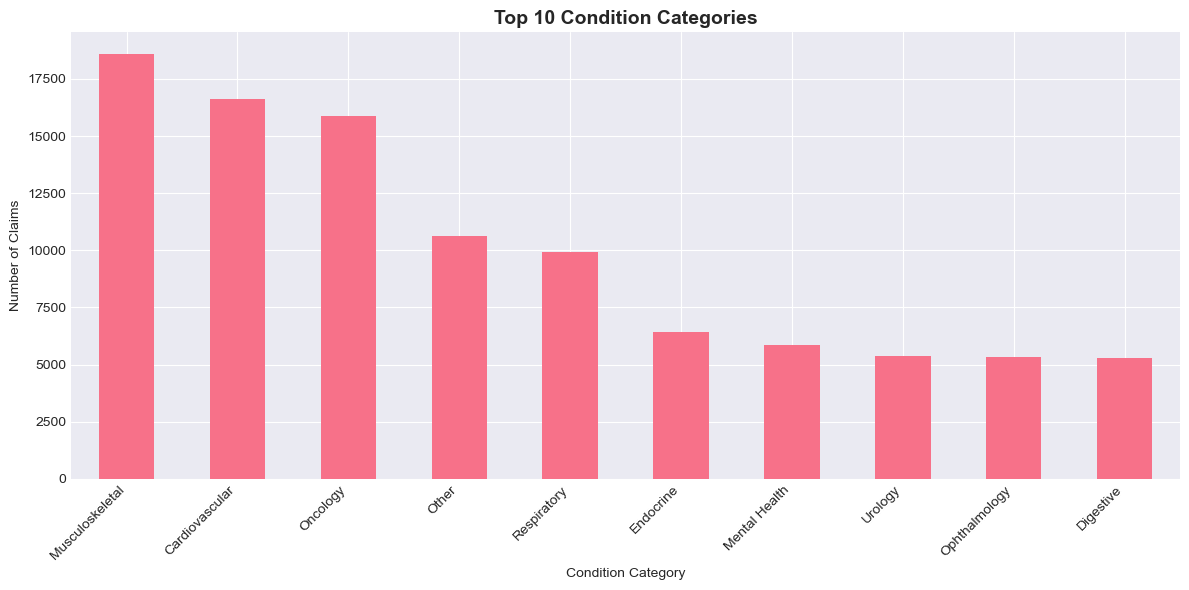

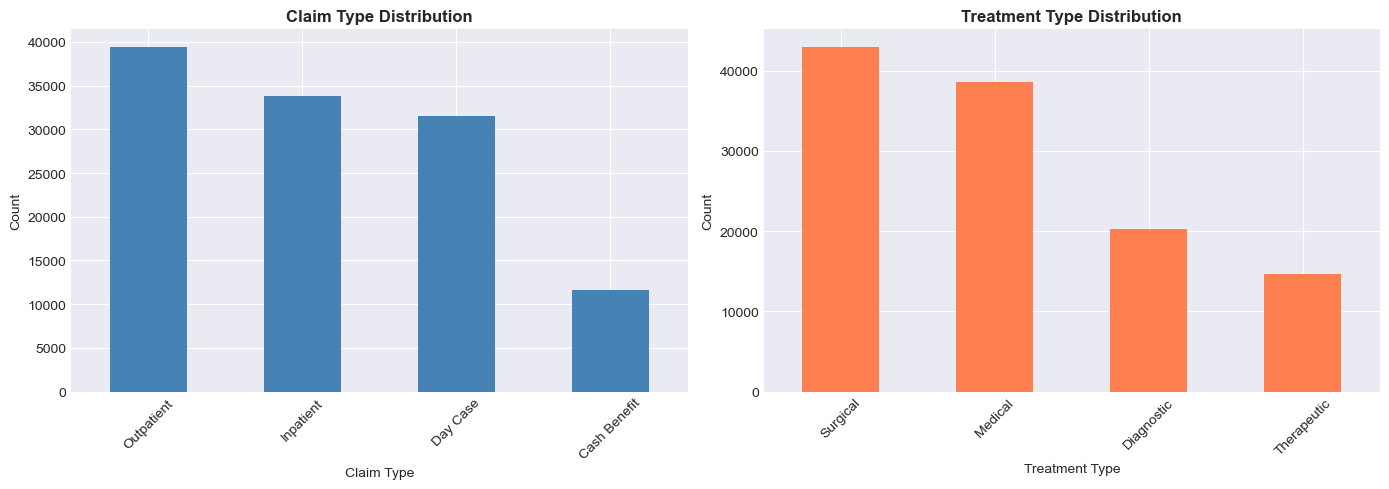

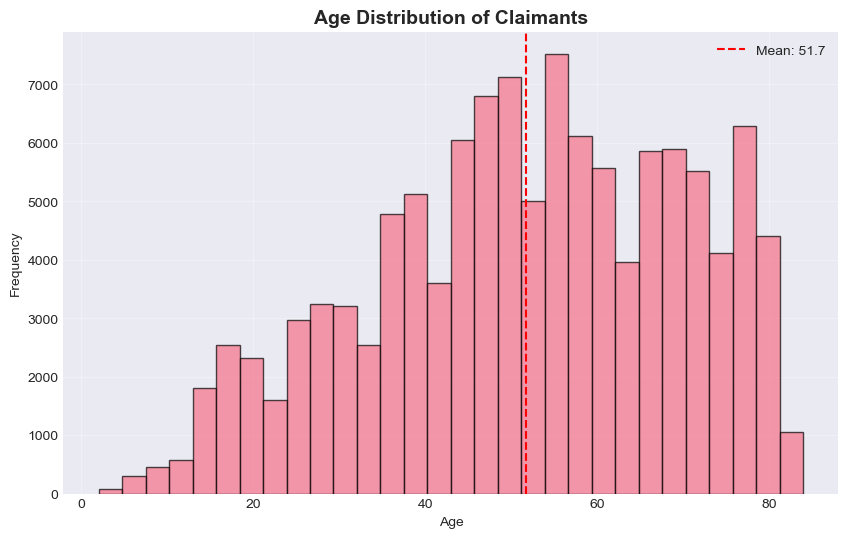


Claims by Year:
      Claim Count  Total Amount
Year                           
2017         3272   37552889.26
2018        14460  157475387.85
2019        21275  227871488.87
2020        22627  247823555.02
2021        22464  243466875.04
2022        20098  226215909.52
2023         9855  121000288.30
2024         2386   32905702.04


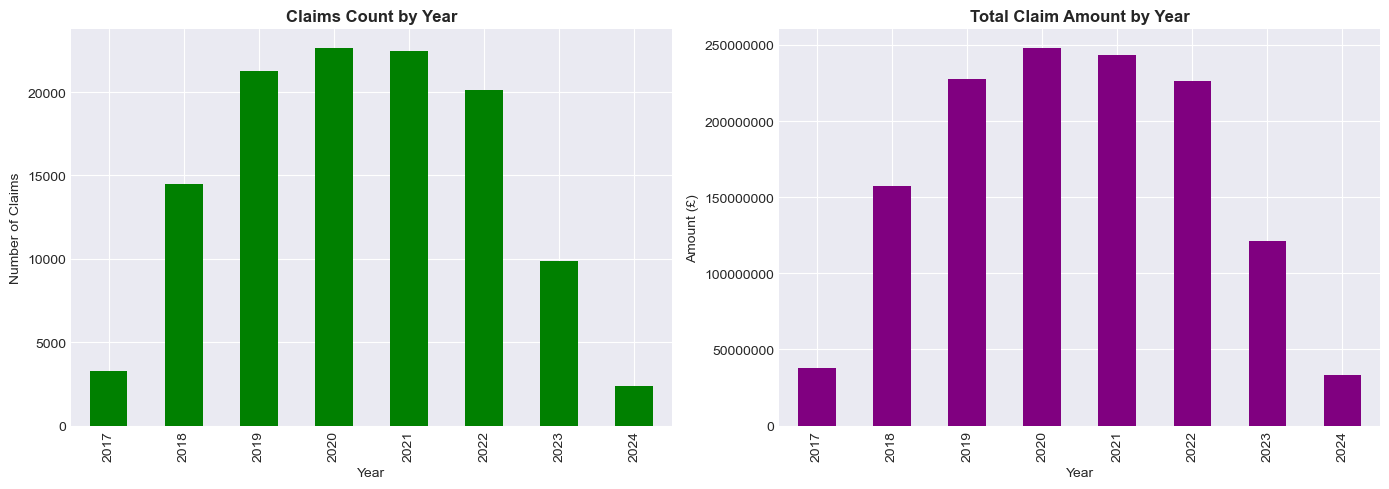

In [2]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             accuracy_score, f1_score)
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")

# %% [markdown]
# ## 2. Load Claims Data

# %%
# Load the claims data
print("Loading claims data...")
claims_df = pd.read_csv('Fianl_claims_data.csv')

# Convert date columns
date_columns = ['Incurred Date', 'Paid Date', 'Contract Start Date', 
                'Contract End Date', 'Admission Date', 'Discharge Date']

for col in date_columns:
    if col in claims_df.columns:
        claims_df[col] = pd.to_datetime(claims_df[col], dayfirst=True, errors='coerce')

print(f"✓ Loaded {len(claims_df):,} claims")
print(f"✓ {claims_df['Unique Member Reference'].nunique():,} unique members")
print(f"✓ Date range: {claims_df['Incurred Date'].min()} to {claims_df['Incurred Date'].max()}")

# Display first few rows
claims_df.head()

# %% [markdown]
# ## 3. Exploratory Data Analysis

# %%
# Basic statistics
print("="*60)
print("CLAIMS DATA SUMMARY")
print("="*60)
print(f"\nTotal Claims: {len(claims_df):,}")
print(f"Unique Members: {claims_df['Unique Member Reference'].nunique():,}")
print(f"Unique Claimants: {claims_df['Claimant Unique ID'].nunique():,}")
print(f"\nDate Range: {claims_df['Incurred Date'].min().date()} to {claims_df['Incurred Date'].max().date()}")
print(f"\nTotal Claim Amount: £{claims_df['Claim Amount'].sum():,.2f}")
print(f"Average Claim Amount: £{claims_df['Claim Amount'].mean():,.2f}")
print(f"Median Claim Amount: £{claims_df['Claim Amount'].median():,.2f}")

# %%
# Condition distribution
print("\nCondition Category Distribution:")
condition_dist = claims_df['Condition Category'].value_counts()
print(condition_dist.head(10))

# Visualize
plt.figure(figsize=(12, 6))
condition_dist.head(10).plot(kind='bar')
plt.title('Top 10 Condition Categories', fontsize=14, fontweight='bold')
plt.xlabel('Condition Category')
plt.ylabel('Number of Claims')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# %%
# Claim type distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Claim Type
claims_df['Claim Type'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Claim Type Distribution', fontweight='bold')
axes[0].set_xlabel('Claim Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Treatment Type
claims_df['Treatment Type'].value_counts().plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Treatment Type Distribution', fontweight='bold')
axes[1].set_xlabel('Treatment Type')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# %%
# Age distribution
plt.figure(figsize=(10, 6))
claims_df['Age'].hist(bins=30, edgecolor='black', alpha=0.7)
plt.title('Age Distribution of Claimants', fontsize=14, fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.axvline(claims_df['Age'].mean(), color='red', linestyle='--', label=f'Mean: {claims_df["Age"].mean():.1f}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# %%
# Claims by year
claims_df['Year'] = claims_df['Incurred Date'].dt.year
yearly_claims = claims_df.groupby('Year').agg({
    'Claim ID': 'count',
    'Claim Amount': 'sum'
}).rename(columns={'Claim ID': 'Claim Count', 'Claim Amount': 'Total Amount'})

print("\nClaims by Year:")
print(yearly_claims)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

yearly_claims['Claim Count'].plot(kind='bar', ax=axes[0], color='green')
axes[0].set_title('Claims Count by Year', fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Claims')

yearly_claims['Total Amount'].plot(kind='bar', ax=axes[1], color='purple')
axes[1].set_title('Total Claim Amount by Year', fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Amount (£)')
axes[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

claims_df = claims_df.drop('Year', axis=1)  # Clean up temporary column

FEATURE ENGINEERING - TRAINING SET
Training data cutoff: 2023-01-30
We'll predict conditions developing in the 12 months after this date

Engineering features up to 2023-01-30...
  Processed 5,000 members...
✓ Engineered features for 7,563 members
✓ High-risk condition rate: 4.93%

Sample of engineered features:
Total features: 39

Feature list:
1. age
2. gender
3. claims_count_6m
4. claims_count_12m
5. claims_count_24m
6. claim_trend
7. days_since_last_claim
8. total_claim_amount_12m
9. avg_claim_amount_12m
10. max_claim_amount_12m
11. hospitalization_rate
12. avg_los
13. max_los
14. diagnostic_ratio
15. surgical_ratio
16. therapeutic_ratio
17. specialist_ratio
18. diagnostic_center_visits
19. has_imaging
20. has_pathology
21. has_therapy
22. has_chemotherapy
23. has_radiotherapy
24. has_physiotherapy
25. has_musculoskeletal
26. has_digestive
27. has_respiratory
28. has_cardiovascular
29. has_mental_health
30. has_oncology
31. has_endocrine
32. has_neurology
33. has_orthopaedics
34. h

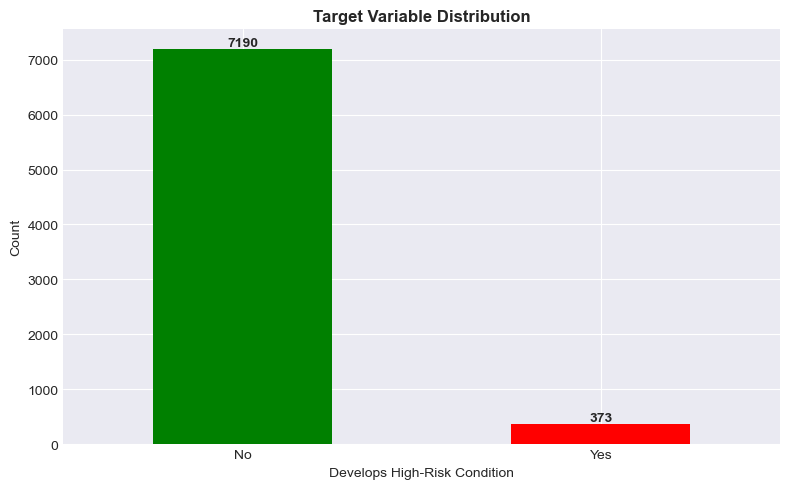

TRAIN/VALIDATION SPLIT
Training set: 6,050 members
  - High risk: 298 (4.93%)
  - Low risk: 5,752

Validation set: 1,513 members
  - High risk: 75 (4.96%)
  - Low risk: 1,438
TRAINING NAIVE BAYES MODEL
✓ Model trained successfully!
✓ Model type: GaussianNB
✓ Number of features: 39
✓ Number of classes: 2
MODEL PERFORMANCE ON VALIDATION SET

Accuracy: 0.9418 (94.18%)

Classification Report:
              precision    recall  f1-score   support

No High Risk     0.9688    0.9701    0.9694      1438
   High Risk     0.4110    0.4000    0.4054        75

    accuracy                         0.9418      1513
   macro avg     0.6899    0.6850    0.6874      1513
weighted avg     0.9411    0.9418    0.9415      1513



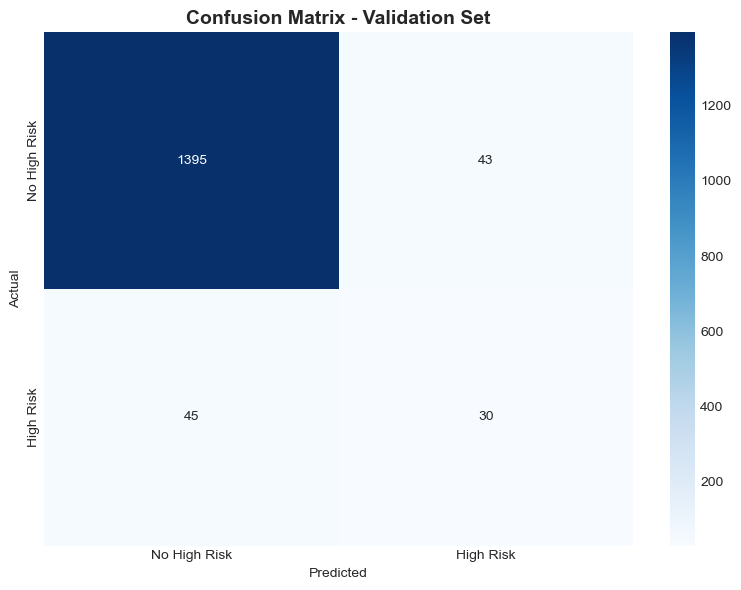


Confusion Matrix Interpretation:
True Negatives (TN): 1,395 - Correctly predicted no high risk
False Positives (FP): 43 - Incorrectly predicted high risk
False Negatives (FN): 45 - Missed high risk cases
True Positives (TP): 30 - Correctly predicted high risk


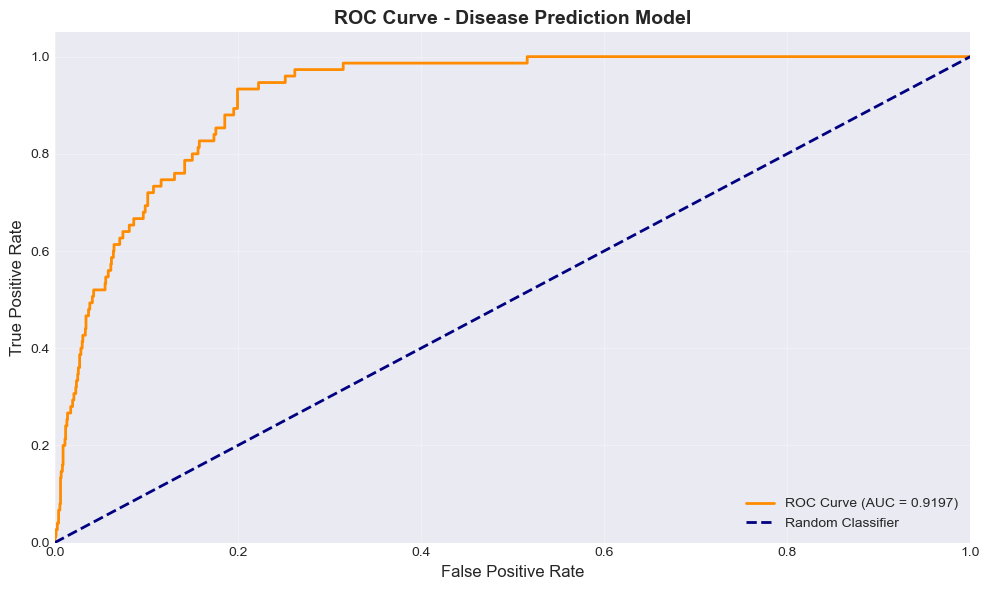


✓ ROC-AUC Score: 0.9197
✓ ROC curve saved as 'roc_curve.png'


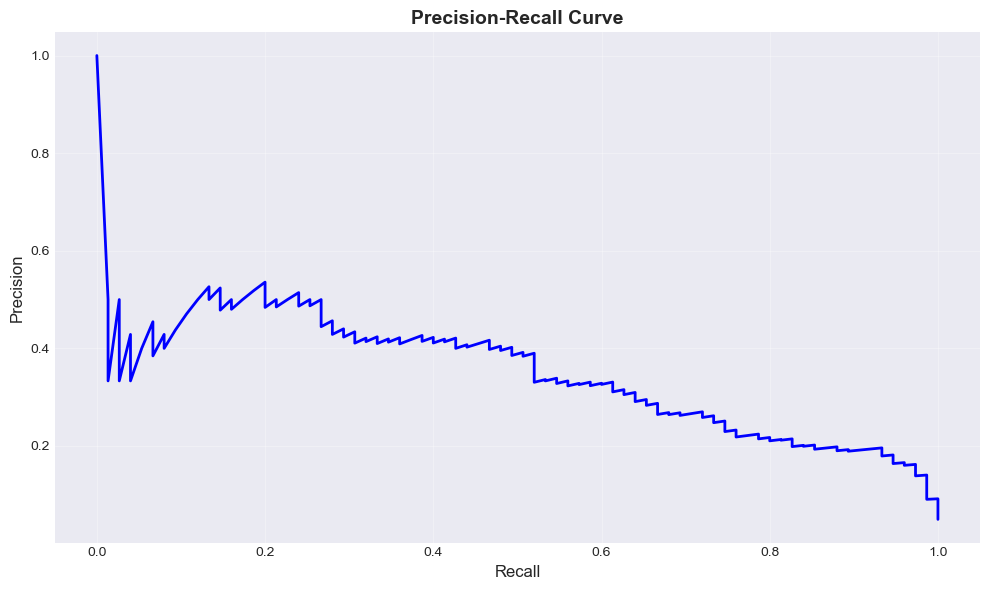

TOP 15 MOST IMPORTANT FEATURES
                  feature  importance
   total_claim_amount_12m   308608.50
     max_claim_amount_12m    34369.83
     avg_claim_amount_12m    11559.79
    days_since_last_claim      654.54
         claims_count_24m       14.45
                      age       13.52
         claims_count_12m       10.69
          claims_count_6m        5.51
                  max_los        4.82
                  avg_los        1.21
  unique_conditions_count        0.56
multiple_hospitalizations        0.48
     high_claim_indicator        0.46
 diagnostic_center_visits        0.45
         frequent_claimer        0.41


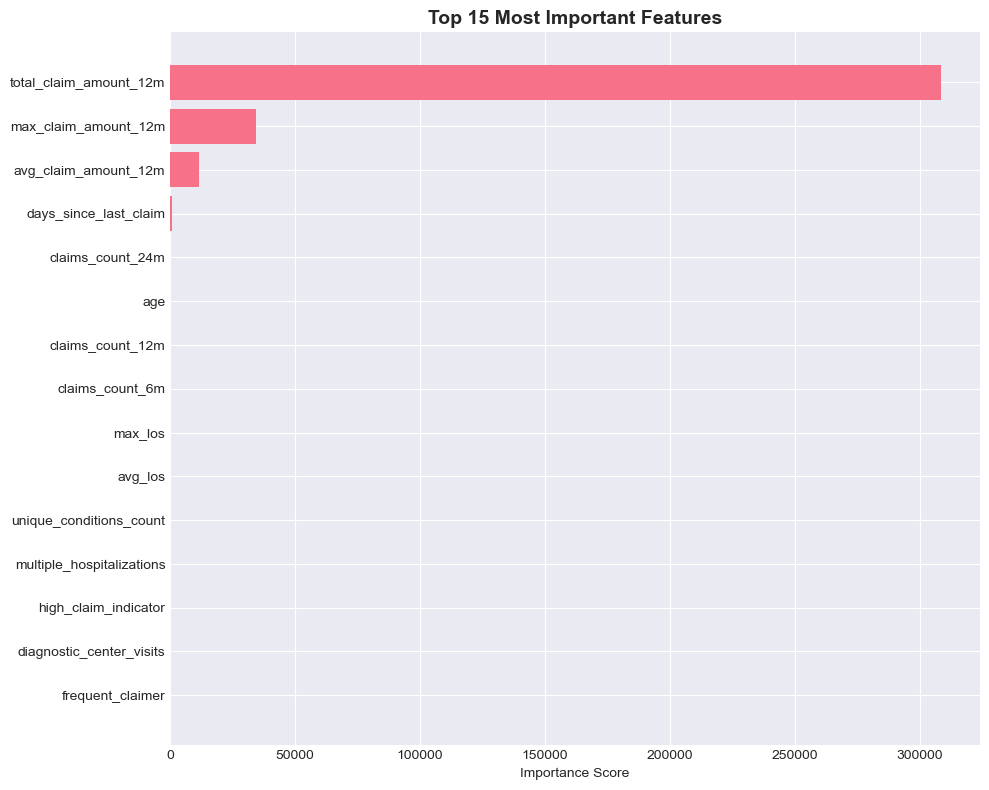

TRAINING DISEASE-SPECIFIC MODELS

Training model for Oncology...
  ✓ Accuracy: 0.9828, AUC: 0.9882
  ✓ Positive cases: 105 (1.39%)

Training model for Cardiovascular...
  ✓ Accuracy: 0.9603, AUC: 0.9398
  ✓ Positive cases: 173 (2.29%)

Training model for Mental Health...
  ✓ Accuracy: 0.9749, AUC: 0.8936
  ✓ Positive cases: 118 (1.56%)

✓ All disease-specific models trained!

DISEASE-SPECIFIC MODEL PERFORMANCE

ONCOLOGY MODEL
----------------------------------------
              precision    recall  f1-score   support

          No      0.997     0.985     0.991      1492
         Yes      0.436     0.810     0.567        21

    accuracy                          0.983      1513
   macro avg      0.717     0.897     0.779      1513
weighted avg      0.989     0.983     0.985      1513


CARDIOVASCULAR MODEL
----------------------------------------
              precision    recall  f1-score   support

          No      0.990     0.970     0.979      1478
         Yes      0.308     0.

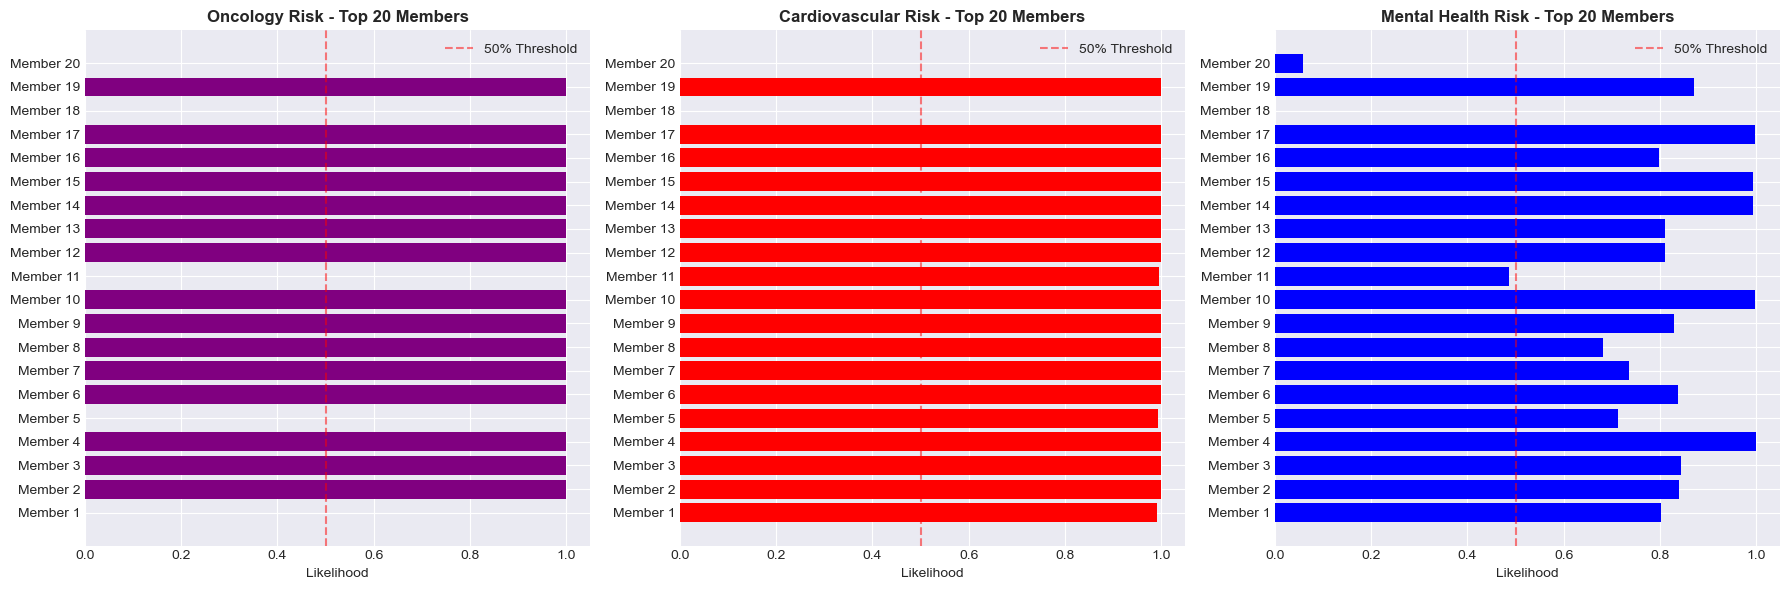

DISEASE LIKELIHOOD DISTRIBUTIONS

Oncology Likelihood:
  Mean: 0.0125
  Median: 0.0000
  Std: 0.1090
  Min: 0.0000
  Max: 1.0000
  Members with >50% likelihood: 95 (1.24%)

Cardiovascular Likelihood:
  Mean: 0.0246
  Median: 0.0000
  Std: 0.1455
  Min: 0.0000
  Max: 1.0000
  Members with >50% likelihood: 185 (2.41%)

Mental Health Likelihood:
  Mean: 0.0202
  Median: 0.0000
  Std: 0.0786
  Min: 0.0000
  Max: 1.0000
  Members with >50% likelihood: 56 (0.73%)


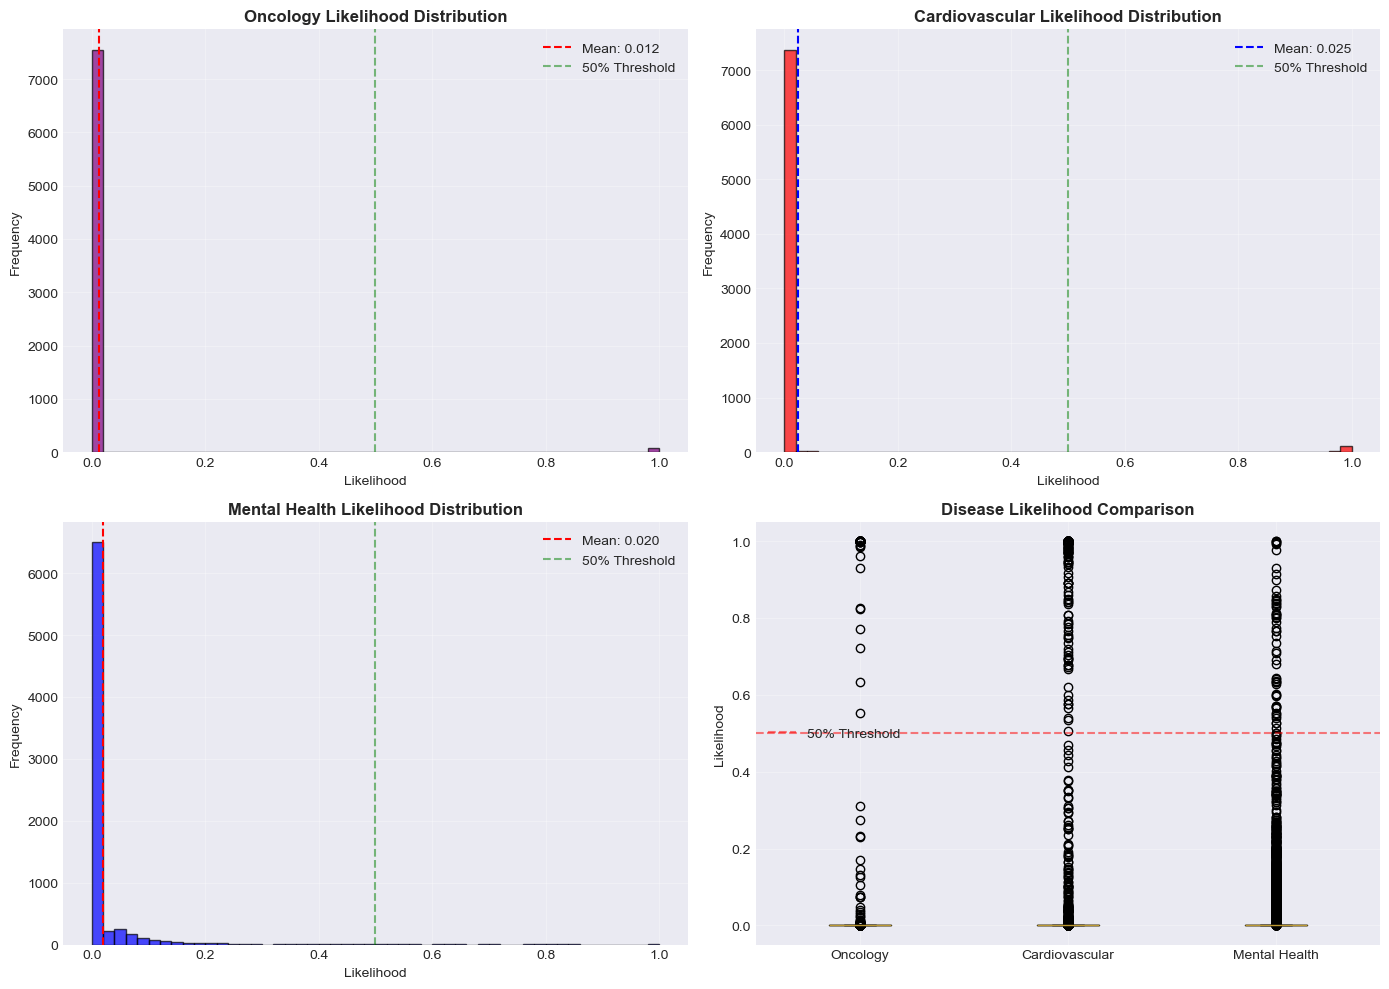


HIGH-RISK MEMBERS BY DISEASE TYPE

Oncology:
  High Risk Members (>50.0%): 95 (1.24%)
  Average Age: 67.5
  Average Claims (12m): 31.8
  Average Likelihood: 98.07%

Cardiovascular:
  High Risk Members (>50.0%): 185 (2.41%)
  Average Age: 66.0
  Average Claims (12m): 28.4
  Average Likelihood: 93.19%

Mental Health:
  High Risk Members (>50.0%): 56 (0.73%)
  Average Age: 68.4
  Average Claims (12m): 34.7
  Average Likelihood: 73.54%

MEMBERS AT HIGH RISK FOR MULTIPLE DISEASES

Members by Number of High-Risk Diseases:
  0 disease(s): 7,483 members (97.57%)
  1 disease(s): 84 members (1.10%)
  2 disease(s): 54 members (0.70%)
  3 disease(s): 48 members (0.63%)

⚠ CRITICAL: 48 members at high risk for ALL 3 diseases!

Top 5 highest combined risk:
  member_id  age  oncology_likelihood  cardiovascular_likelihood  mental_health_likelihood  combined_risk
EMP00001247   76                 1.00                       1.00                      1.00           1.00
EMP00004998   81                 1

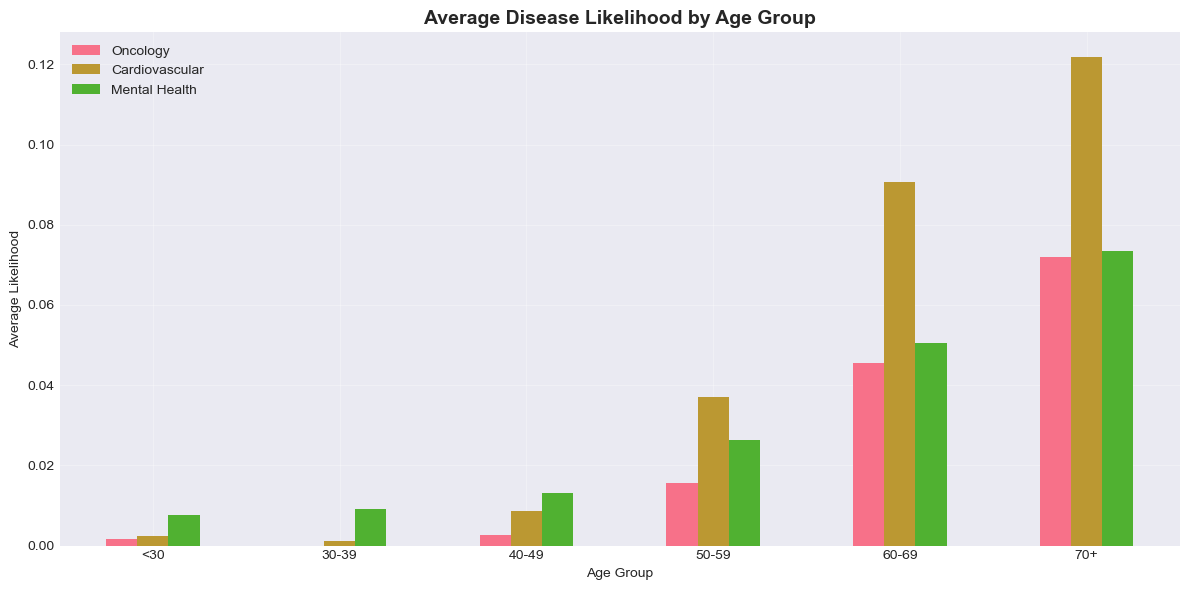

RISK DISTRIBUTION ANALYSIS

Total Members Analyzed: 7,669

Risk Category Distribution:
risk_category
Low          7384
Medium         29
High           28
Very High     228
Name: count, dtype: int64

Percentage Distribution:
risk_category
Low         96.28
Medium       0.38
High         0.37
Very High    2.97
Name: proportion, dtype: float64


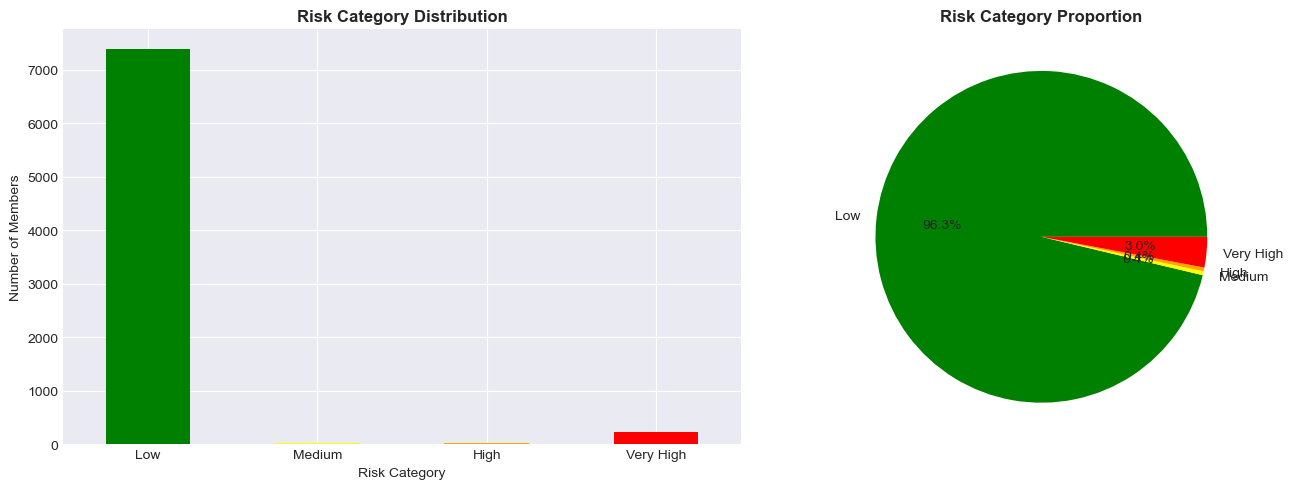

In [3]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             accuracy_score, f1_score)
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")

# %% [markdown]
# ## 2. Load Claims Data

# %%
# Load the claims data
print("Loading claims data...")
claims_df = pd.read_csv('Fianl_claims_data.csv')

# Convert date columns
date_columns = ['Incurred Date', 'Paid Date', 'Contract Start Date', 
                'Contract End Date', 'Admission Date', 'Discharge Date']

for col in date_columns:
    if col in claims_df.columns:
        claims_df[col] = pd.to_datetime(claims_df[col], dayfirst=True, errors='coerce')

print(f"✓ Loaded {len(claims_df):,} claims")
print(f"✓ {claims_df['Unique Member Reference'].nunique():,} unique members")
print(f"✓ Date range: {claims_df['Incurred Date'].min()} to {claims_df['Incurred Date'].max()}")

# Display first few rows
claims_df.head()

# %% [markdown]
# ## 3. Exploratory Data Analysis

# %%
# Basic statistics
print("="*60)
print("CLAIMS DATA SUMMARY")
print("="*60)
print(f"\nTotal Claims: {len(claims_df):,}")
print(f"Unique Members: {claims_df['Unique Member Reference'].nunique():,}")
print(f"Unique Claimants: {claims_df['Claimant Unique ID'].nunique():,}")
print(f"\nDate Range: {claims_df['Incurred Date'].min().date()} to {claims_df['Incurred Date'].max().date()}")
print(f"\nTotal Claim Amount: £{claims_df['Claim Amount'].sum():,.2f}")
print(f"Average Claim Amount: £{claims_df['Claim Amount'].mean():,.2f}")
print(f"Median Claim Amount: £{claims_df['Claim Amount'].median():,.2f}")

# %%
# Condition distribution
print("\nCondition Category Distribution:")
condition_dist = claims_df['Condition Category'].value_counts()
print(condition_dist.head(10))

# Visualize
plt.figure(figsize=(12, 6))
condition_dist.head(10).plot(kind='bar')
plt.title('Top 10 Condition Categories', fontsize=14, fontweight='bold')
plt.xlabel('Condition Category')
plt.ylabel('Number of Claims')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# %%
# Claim type distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Claim Type
claims_df['Claim Type'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Claim Type Distribution', fontweight='bold')
axes[0].set_xlabel('Claim Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Treatment Type
claims_df['Treatment Type'].value_counts().plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Treatment Type Distribution', fontweight='bold')
axes[1].set_xlabel('Treatment Type')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# %%
# Age distribution
plt.figure(figsize=(10, 6))
claims_df['Age'].hist(bins=30, edgecolor='black', alpha=0.7)
plt.title('Age Distribution of Claimants', fontsize=14, fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.axvline(claims_df['Age'].mean(), color='red', linestyle='--', label=f'Mean: {claims_df["Age"].mean():.1f}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# %%
# Claims by year
claims_df['Year'] = claims_df['Incurred Date'].dt.year
yearly_claims = claims_df.groupby('Year').agg({
    'Claim ID': 'count',
    'Claim Amount': 'sum'
}).rename(columns={'Claim ID': 'Claim Count', 'Claim Amount': 'Total Amount'})

print("\nClaims by Year:")
print(yearly_claims)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

yearly_claims['Claim Count'].plot(kind='bar', ax=axes[0], color='green')
axes[0].set_title('Claims Count by Year', fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Claims')

yearly_claims['Total Amount'].plot(kind='bar', ax=axes[1], color='purple')
axes[1].set_title('Total Claim Amount by Year', fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Amount (£)')
axes[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

claims_df = claims_df.drop('Year', axis=1)  # Clean up temporary column

# %% [markdown]
# ## 4. Feature Engineering

# %%
def engineer_features(claims_df, prediction_date=None, verbose=True):
    """
    Engineer features from claims history for each member
    """
    
    if prediction_date is None:
        prediction_date = claims_df['Incurred Date'].max()
    
    if verbose:
        print(f"\nEngineering features up to {prediction_date.strftime('%Y-%m-%d')}...")
    
    # Filter claims before prediction date
    historical_claims = claims_df[claims_df['Incurred Date'] <= prediction_date].copy()
    
    member_features = []
    
    for i, member_id in enumerate(historical_claims['Unique Member Reference'].unique()):
        if verbose and (i + 1) % 5000 == 0:
            print(f"  Processed {i+1:,} members...")
        
        member_claims = historical_claims[
            historical_claims['Unique Member Reference'] == member_id
        ].sort_values('Incurred Date')
        
        if len(member_claims) == 0:
            continue
        
        # Get latest member info
        latest_claim = member_claims.iloc[-1]
        
        # Calculate time windows
        last_claim_date = member_claims['Incurred Date'].max()
        lookback_6m = last_claim_date - timedelta(days=180)
        lookback_12m = last_claim_date - timedelta(days=365)
        lookback_24m = last_claim_date - timedelta(days=730)
        
        # Claims in different time windows
        claims_6m = member_claims[member_claims['Incurred Date'] >= lookback_6m]
        claims_12m = member_claims[member_claims['Incurred Date'] >= lookback_12m]
        claims_24m = member_claims[member_claims['Incurred Date'] >= lookback_24m]
        
        # === DEMOGRAPHIC FEATURES ===
        age = latest_claim.get('Age', 40)
        gender_encoded = 1 if latest_claim.get('Gender') == 'Male' else 0
        
        # === TEMPORAL FEATURES ===
        claims_count_6m = len(claims_6m)
        claims_count_12m = len(claims_12m)
        claims_count_24m = len(claims_24m)
        
        # Claim frequency trend
        if claims_count_6m > claims_count_12m * 0.6:
            claim_trend = 1  # Increasing
        elif claims_count_6m < claims_count_12m * 0.3:
            claim_trend = -1  # Decreasing
        else:
            claim_trend = 0  # Stable
        
        # Days since last claim
        days_since_last_claim = (prediction_date - last_claim_date).days
        
        # === TREATMENT INTENSITY FEATURES ===
        total_claim_amount_12m = claims_12m['Claim Amount'].sum()
        avg_claim_amount_12m = claims_12m['Claim Amount'].mean()
        max_claim_amount_12m = claims_12m['Claim Amount'].max()
        
        # Hospitalization rate
        inpatient_claims = claims_12m[claims_12m['Claim Type'] == 'Inpatient']
        hospitalization_rate = len(inpatient_claims) / len(claims_12m) if len(claims_12m) > 0 else 0
        
        # Average length of stay
        avg_los = claims_12m['Calculate Length of Service'].mean()
        max_los = claims_12m['Calculate Length of Service'].max()
        
        # === DIAGNOSTIC & TREATMENT PATTERN FEATURES ===
        diagnostic_claims = claims_12m[claims_12m['Treatment Type'] == 'Diagnostic']
        surgical_claims = claims_12m[claims_12m['Treatment Type'] == 'Surgical']
        therapeutic_claims = claims_12m[claims_12m['Treatment Type'] == 'Therapeutic']
        
        diagnostic_ratio = len(diagnostic_claims) / len(claims_12m) if len(claims_12m) > 0 else 0
        surgical_ratio = len(surgical_claims) / len(claims_12m) if len(claims_12m) > 0 else 0
        therapeutic_ratio = len(therapeutic_claims) / len(claims_12m) if len(claims_12m) > 0 else 0
        
        # Specialist visits
        hospital_visits = claims_12m[claims_12m['Provider Type'] == 'Hospital']
        specialist_ratio = len(hospital_visits) / len(claims_12m) if len(claims_12m) > 0 else 0
        
        # Diagnostic center visits (imaging/tests)
        diagnostic_center_visits = len(claims_12m[claims_12m['Provider Type'] == 'Diagnostic Center'])
        
        # === ANCILLARY SERVICE FEATURES ===
        ancillary_services = claims_12m['Ancillary Service Type'].dropna().tolist()
        has_imaging = any('Imaging' in str(s) for s in ancillary_services)
        has_pathology = any('Pathology' in str(s) for s in ancillary_services)
        has_therapy = any('Therapy' in str(s) for s in ancillary_services)
        has_chemotherapy = any('Chemotherapy' in str(s) for s in ancillary_services)
        has_radiotherapy = any('Radiotherapy' in str(s) for s in ancillary_services)
        has_physiotherapy = any('Physiotherapy' in str(s) for s in ancillary_services)
        
        # === CONDITION HISTORY FEATURES ===
        all_conditions = member_claims['Condition Category'].unique().tolist()
        
        # Pre-existing condition indicators
        has_musculoskeletal = 'Musculoskeletal' in all_conditions
        has_digestive = 'Digestive' in all_conditions
        has_respiratory = 'Respiratory' in all_conditions
        has_cardiovascular = 'Cardiovascular' in all_conditions
        has_mental_health = 'Mental Health' in all_conditions
        has_oncology = 'Oncology' in all_conditions
        has_endocrine = 'Endocrine' in all_conditions
        has_neurology = 'Neurology' in all_conditions
        has_orthopaedics = 'Orthopaedics' in all_conditions
        has_rheumatology = 'Rheumatology' in all_conditions
        
        # Count unique condition categories
        unique_conditions_count = len(all_conditions)
        
        # === RISK INDICATORS ===
        # High claim amount indicator
        high_claim_indicator = 1 if avg_claim_amount_12m > 5000 else 0
        
        # Frequent claimer
        frequent_claimer = 1 if claims_count_12m > 8 else 0
        
        # Multiple hospitalizations
        multiple_hospitalizations = 1 if len(inpatient_claims) > 2 else 0
        
        # Escalating care (increase in claim amounts)
        if len(claims_12m) >= 2:
            first_half = claims_12m.iloc[:len(claims_12m)//2]['Claim Amount'].mean()
            second_half = claims_12m.iloc[len(claims_12m)//2:]['Claim Amount'].mean()
            escalating_costs = 1 if second_half > first_half * 1.3 else 0
        else:
            escalating_costs = 0
        
        # === TARGET VARIABLE ===
        # Check if member develops high-risk condition in future
        future_claims = claims_df[
            (claims_df['Unique Member Reference'] == member_id) &
            (claims_df['Incurred Date'] > prediction_date) &
            (claims_df['Incurred Date'] <= prediction_date + timedelta(days=365))
        ]
        
        high_risk_conditions = ['Oncology', 'Cardiovascular', 'Mental Health']
        
        # Target: Will develop high-risk condition in next 12 months?
        develops_high_risk = any(
            cond in high_risk_conditions 
            for cond in future_claims['Condition Category'].unique()
        )
        
        # Specific condition targets
        develops_oncology = 'Oncology' in future_claims['Condition Category'].values
        develops_cardiovascular = 'Cardiovascular' in future_claims['Condition Category'].values
        develops_mental_health = 'Mental Health' in future_claims['Condition Category'].values
        
        # Compile features
        features = {
            'member_id': member_id,
            'age': age,
            'gender': gender_encoded,
            'claims_count_6m': claims_count_6m,
            'claims_count_12m': claims_count_12m,
            'claims_count_24m': claims_count_24m,
            'claim_trend': claim_trend,
            'days_since_last_claim': days_since_last_claim,
            'total_claim_amount_12m': total_claim_amount_12m,
            'avg_claim_amount_12m': avg_claim_amount_12m,
            'max_claim_amount_12m': max_claim_amount_12m,
            'hospitalization_rate': hospitalization_rate,
            'avg_los': avg_los,
            'max_los': max_los,
            'diagnostic_ratio': diagnostic_ratio,
            'surgical_ratio': surgical_ratio,
            'therapeutic_ratio': therapeutic_ratio,
            'specialist_ratio': specialist_ratio,
            'diagnostic_center_visits': diagnostic_center_visits,
            'has_imaging': int(has_imaging),
            'has_pathology': int(has_pathology),
            'has_therapy': int(has_therapy),
            'has_chemotherapy': int(has_chemotherapy),
            'has_radiotherapy': int(has_radiotherapy),
            'has_physiotherapy': int(has_physiotherapy),
            'has_musculoskeletal': int(has_musculoskeletal),
            'has_digestive': int(has_digestive),
            'has_respiratory': int(has_respiratory),
            'has_cardiovascular': int(has_cardiovascular),
            'has_mental_health': int(has_mental_health),
            'has_oncology': int(has_oncology),
            'has_endocrine': int(has_endocrine),
            'has_neurology': int(has_neurology),
            'has_orthopaedics': int(has_orthopaedics),
            'has_rheumatology': int(has_rheumatology),
            'unique_conditions_count': unique_conditions_count,
            'high_claim_indicator': high_claim_indicator,
            'frequent_claimer': frequent_claimer,
            'multiple_hospitalizations': multiple_hospitalizations,
            'escalating_costs': escalating_costs,
            # Targets
            'develops_high_risk': int(develops_high_risk),
            'develops_oncology': int(develops_oncology),
            'develops_cardiovascular': int(develops_cardiovascular),
            'develops_mental_health': int(develops_mental_health)
        }
        
        member_features.append(features)
    
    features_df = pd.DataFrame(member_features)
    
    if verbose:
        print(f"✓ Engineered features for {len(features_df):,} members")
        print(f"✓ High-risk condition rate: {features_df['develops_high_risk'].mean()*100:.2f}%")
    
    return features_df

# %%
# Define training cutoff date (we'll train on data before this date)
training_cutoff = pd.to_datetime('2023-01-30')

print("="*60)
print("FEATURE ENGINEERING - TRAINING SET")
print("="*60)
print(f"Training data cutoff: {training_cutoff.strftime('%Y-%m-%d')}")
print(f"We'll predict conditions developing in the 12 months after this date")

# Engineer features
training_features = engineer_features(claims_df, prediction_date=training_cutoff)

# Display sample features
print("\nSample of engineered features:")
training_features.head()

# %% [markdown]
# ## 5. Prepare Training Data

# %%
# Select feature columns (exclude ID and target columns)
exclude_cols = ['member_id', 'develops_high_risk', 'develops_oncology', 
               'develops_cardiovascular', 'develops_mental_health']

feature_columns = [col for col in training_features.columns if col not in exclude_cols]

print(f"Total features: {len(feature_columns)}")
print("\nFeature list:")
for i, col in enumerate(feature_columns, 1):
    print(f"{i}. {col}")

# %%
# Prepare X and y
X = training_features[feature_columns].fillna(0)
y = training_features['develops_high_risk']

print("\n" + "="*60)
print("TARGET VARIABLE DISTRIBUTION")
print("="*60)
print(f"Total members: {len(y):,}")
print(f"Develops high-risk condition: {y.sum():,} ({y.mean()*100:.2f}%)")
print(f"Does not develop: {(~y.astype(bool)).sum():,} ({(1-y.mean())*100:.2f}%)")

# Visualize class distribution
fig, ax = plt.subplots(figsize=(8, 5))
y.value_counts().plot(kind='bar', color=['green', 'red'], ax=ax)
ax.set_title('Target Variable Distribution', fontweight='bold')
ax.set_xlabel('Develops High-Risk Condition')
ax.set_xticklabels(['No', 'Yes'], rotation=0)
ax.set_ylabel('Count')
for i, v in enumerate(y.value_counts().values):
    ax.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# %%
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("="*60)
print("TRAIN/VALIDATION SPLIT")
print("="*60)
print(f"Training set: {len(X_train):,} members")
print(f"  - High risk: {y_train.sum():,} ({y_train.mean()*100:.2f}%)")
print(f"  - Low risk: {(~y_train.astype(bool)).sum():,}")

print(f"\nValidation set: {len(X_val):,} members")
print(f"  - High risk: {y_val.sum():,} ({y_val.mean()*100:.2f}%)")
print(f"  - Low risk: {(~y_val.astype(bool)).sum():,}")

# %% [markdown]
# ## 6. Train Naive Bayes Model

# %%
print("="*60)
print("TRAINING NAIVE BAYES MODEL")
print("="*60)

# Initialize and train model
model = GaussianNB()
model.fit(X_train, y_train)

print("✓ Model trained successfully!")
print(f"✓ Model type: {type(model).__name__}")
print(f"✓ Number of features: {X_train.shape[1]}")
print(f"✓ Number of classes: {len(model.classes_)}")

# %% [markdown]
# ## 7. Model Evaluation

# %%
# Make predictions on validation set
y_pred_val = model.predict(X_val)
y_pred_proba_val = model.predict_proba(X_val)

print("="*60)
print("MODEL PERFORMANCE ON VALIDATION SET")
print("="*60)

# Accuracy
accuracy = accuracy_score(y_val, y_pred_val)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val, 
                          target_names=['No High Risk', 'High Risk'],
                          digits=4))

# %%
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No High Risk', 'High Risk'],
            yticklabels=['No High Risk', 'High Risk'])
plt.title('Confusion Matrix - Validation Set', fontweight='bold', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Interpretation:")
print(f"True Negatives (TN): {cm[0,0]:,} - Correctly predicted no high risk")
print(f"False Positives (FP): {cm[0,1]:,} - Incorrectly predicted high risk")
print(f"False Negatives (FN): {cm[1,0]:,} - Missed high risk cases")
print(f"True Positives (TP): {cm[1,1]:,} - Correctly predicted high risk")

# %%
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_val[:, 1])
roc_auc = roc_auc_score(y_val, y_pred_proba_val[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Disease Prediction Model', fontweight='bold', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ ROC-AUC Score: {roc_auc:.4f}")
print("✓ ROC curve saved as 'roc_curve.png'")

# %%
# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_val, y_pred_proba_val[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontweight='bold', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# %%
# Feature Importance (based on difference in class means)
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': np.abs(model.theta_[1] - model.theta_[0])
}).sort_values('importance', ascending=False)

print("="*60)
print("TOP 15 MOST IMPORTANT FEATURES")
print("="*60)
print(feature_importance.head(15).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score')
plt.title('Top 15 Most Important Features', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 8. Train Individual Disease Models
# 
# Now we'll train separate models for each disease type to get individual likelihoods

# %%
print("="*60)
print("TRAINING DISEASE-SPECIFIC MODELS")
print("="*60)

# Prepare data for each disease
disease_models = {}
disease_targets = {
    'Oncology': 'develops_oncology',
    'Cardiovascular': 'develops_cardiovascular',
    'Mental Health': 'develops_mental_health'
}

# Train a model for each disease
for disease_name, target_col in disease_targets.items():
    print(f"\nTraining model for {disease_name}...")
    
    # Prepare target
    y_disease = training_features[target_col]
    
    # Split data
    X_train_disease, X_val_disease, y_train_disease, y_val_disease = train_test_split(
        X, y_disease, test_size=0.2, random_state=42, stratify=y_disease
    )
    
    # Train model
    model_disease = GaussianNB()
    model_disease.fit(X_train_disease, y_train_disease)
    
    # Evaluate
    y_pred_disease = model_disease.predict(X_val_disease)
    y_pred_proba_disease = model_disease.predict_proba(X_val_disease)
    
    accuracy = accuracy_score(y_val_disease, y_pred_disease)
    
    try:
        auc = roc_auc_score(y_val_disease, y_pred_proba_disease[:, 1])
        print(f"  ✓ Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    except:
        print(f"  ✓ Accuracy: {accuracy:.4f}")
    
    print(f"  ✓ Positive cases: {y_disease.sum()} ({y_disease.mean()*100:.2f}%)")
    
    # Store model
    disease_models[disease_name] = model_disease

print("\n✓ All disease-specific models trained!")

# %%
# Evaluate each disease model in detail
print("\n" + "="*60)
print("DISEASE-SPECIFIC MODEL PERFORMANCE")
print("="*60)

for disease_name, target_col in disease_targets.items():
    print(f"\n{disease_name.upper()} MODEL")
    print("-" * 40)
    
    model_disease = disease_models[disease_name]
    y_disease = training_features[target_col]
    
    X_train_disease, X_val_disease, y_train_disease, y_val_disease = train_test_split(
        X, y_disease, test_size=0.2, random_state=42, stratify=y_disease
    )
    
    y_pred_disease = model_disease.predict(X_val_disease)
    y_pred_proba_disease = model_disease.predict_proba(X_val_disease)
    
    print(classification_report(y_val_disease, y_pred_disease, 
                               target_names=['No', 'Yes'], digits=3))

# %% [markdown]
# ## 9. Make Predictions for All Diseases

# %%
# Engineer features for prediction (using more recent data)
prediction_cutoff = pd.to_datetime('2023-12-31')

print("="*60)
print("PREDICTIONS ON NEW MEMBERS - ALL DISEASES")
print("="*60)
print(f"Prediction data cutoff: {prediction_cutoff.strftime('%Y-%m-%d')}")

prediction_features = engineer_features(claims_df, prediction_date=prediction_cutoff)

# %%
# Prepare prediction data
X_pred = prediction_features[feature_columns].fillna(0)

# Make predictions for general high risk
predictions = model.predict(X_pred)
probabilities = model.predict_proba(X_pred)

# Create comprehensive risk report
risk_report = prediction_features[['member_id']].copy()

# Overall high risk prediction
risk_report['overall_high_risk'] = predictions
risk_report['overall_risk_probability'] = probabilities[:, 1]

# Individual disease predictions
for disease_name, disease_model in disease_models.items():
    disease_pred = disease_model.predict(X_pred)
    disease_proba = disease_model.predict_proba(X_pred)
    
    risk_report[f'{disease_name.lower().replace(" ", "_")}_prediction'] = disease_pred
    risk_report[f'{disease_name.lower().replace(" ", "_")}_likelihood'] = disease_proba[:, 1]

# Risk categorization for overall risk
risk_report['risk_category'] = pd.cut(
    risk_report['overall_risk_probability'],
    bins=[0, 0.25, 0.50, 0.75, 1.0],
    labels=['Low', 'Medium', 'High', 'Very High']
)

# Add key member information
risk_report['age'] = prediction_features['age'].values
risk_report['gender'] = prediction_features['gender'].map({1: 'Male', 0: 'Female'})
risk_report['claims_12m'] = prediction_features['claims_count_12m'].values
risk_report['avg_claim_amount'] = prediction_features['avg_claim_amount_12m'].values
risk_report['hospitalization_rate'] = prediction_features['hospitalization_rate'].values

# Add condition history flags
risk_report['has_cardiovascular_history'] = prediction_features['has_cardiovascular'].values
risk_report['has_oncology_history'] = prediction_features['has_oncology'].values
risk_report['has_mental_health_history'] = prediction_features['has_mental_health'].values

print(f"✓ Generated predictions for {len(risk_report):,} members")

# Display sample predictions with all disease likelihoods
print("\nSample Predictions (First 10 Members):")
display_cols = ['member_id', 'age', 'gender', 'overall_risk_probability', 
                'oncology_likelihood', 'cardiovascular_likelihood', 
                'mental_health_likelihood', 'risk_category']
print(risk_report[display_cols].head(10).to_string(index=False))

# %%
# Show detailed view for a specific high-risk member
print("\n" + "="*60)
print("DETAILED EXAMPLE: HIGH-RISK MEMBER ANALYSIS")
print("="*60)

# Find a member with high overall risk
high_risk_member = risk_report.nlargest(1, 'overall_risk_probability').iloc[0]

print(f"\nMember ID: {high_risk_member['member_id']}")
print(f"Age: {high_risk_member['age']}")
print(f"Gender: {high_risk_member['gender']}")
print(f"Claims (12m): {high_risk_member['claims_12m']}")
print(f"Avg Claim Amount: £{high_risk_member['avg_claim_amount']:,.2f}")
print(f"Hospitalization Rate: {high_risk_member['hospitalization_rate']:.2%}")

print(f"\n{'Disease Type':<20} {'Likelihood':<15} {'Risk Level'}")
print("-" * 50)

# Overall risk
overall_prob = high_risk_member['overall_risk_probability']
print(f"{'Overall High Risk':<20} {overall_prob:<15.2%} {high_risk_member['risk_category']}")

# Individual diseases
print(f"{'Oncology':<20} {high_risk_member['oncology_likelihood']:<15.2%} {'High' if high_risk_member['oncology_likelihood'] > 0.5 else 'Low'}")
print(f"{'Cardiovascular':<20} {high_risk_member['cardiovascular_likelihood']:<15.2%} {'High' if high_risk_member['cardiovascular_likelihood'] > 0.5 else 'Low'}")
print(f"{'Mental Health':<20} {high_risk_member['mental_health_likelihood']:<15.2%} {'High' if high_risk_member['mental_health_likelihood'] > 0.5 else 'Low'}")

print(f"\nCondition History:")
print(f"  - Cardiovascular: {'Yes' if high_risk_member['has_cardiovascular_history'] else 'No'}")
print(f"  - Oncology: {'Yes' if high_risk_member['has_oncology_history'] else 'No'}")
print(f"  - Mental Health: {'Yes' if high_risk_member['has_mental_health_history'] else 'No'}")

# %%
# Visualize disease likelihoods for top 20 high-risk members
top_20_risk = risk_report.nlargest(20, 'overall_risk_probability')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Oncology
axes[0].barh(range(len(top_20_risk)), top_20_risk['oncology_likelihood'], color='purple')
axes[0].set_yticks(range(len(top_20_risk)))
axes[0].set_yticklabels([f"Member {i+1}" for i in range(len(top_20_risk))])
axes[0].set_xlabel('Likelihood')
axes[0].set_title('Oncology Risk - Top 20 Members', fontweight='bold')
axes[0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='50% Threshold')
axes[0].legend()

# Cardiovascular
axes[1].barh(range(len(top_20_risk)), top_20_risk['cardiovascular_likelihood'], color='red')
axes[1].set_yticks(range(len(top_20_risk)))
axes[1].set_yticklabels([f"Member {i+1}" for i in range(len(top_20_risk))])
axes[1].set_xlabel('Likelihood')
axes[1].set_title('Cardiovascular Risk - Top 20 Members', fontweight='bold')
axes[1].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='50% Threshold')
axes[1].legend()

# Mental Health
axes[2].barh(range(len(top_20_risk)), top_20_risk['mental_health_likelihood'], color='blue')
axes[2].set_yticks(range(len(top_20_risk)))
axes[2].set_yticklabels([f"Member {i+1}" for i in range(len(top_20_risk))])
axes[2].set_xlabel('Likelihood')
axes[2].set_title('Mental Health Risk - Top 20 Members', fontweight='bold')
axes[2].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='50% Threshold')
axes[2].legend()

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 10. Disease Likelihood Distribution Analysis

# %%
# Analyze distribution of disease likelihoods
print("="*60)
print("DISEASE LIKELIHOOD DISTRIBUTIONS")
print("="*60)

for disease in ['oncology', 'cardiovascular', 'mental_health']:
    col_name = f'{disease}_likelihood'
    print(f"\n{disease.replace('_', ' ').title()} Likelihood:")
    print(f"  Mean: {risk_report[col_name].mean():.4f}")
    print(f"  Median: {risk_report[col_name].median():.4f}")
    print(f"  Std: {risk_report[col_name].std():.4f}")
    print(f"  Min: {risk_report[col_name].min():.4f}")
    print(f"  Max: {risk_report[col_name].max():.4f}")
    print(f"  Members with >50% likelihood: {(risk_report[col_name] > 0.5).sum():,} ({(risk_report[col_name] > 0.5).mean()*100:.2f}%)")

# %%
# Visualize disease likelihood distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Oncology
axes[0, 0].hist(risk_report['oncology_likelihood'], bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(risk_report['oncology_likelihood'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {risk_report["oncology_likelihood"].mean():.3f}')
axes[0, 0].axvline(0.5, color='green', linestyle='--', alpha=0.5, label='50% Threshold')
axes[0, 0].set_title('Oncology Likelihood Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Likelihood')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Cardiovascular
axes[0, 1].hist(risk_report['cardiovascular_likelihood'], bins=50, color='red', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(risk_report['cardiovascular_likelihood'].mean(), color='blue', linestyle='--',
                   label=f'Mean: {risk_report["cardiovascular_likelihood"].mean():.3f}')
axes[0, 1].axvline(0.5, color='green', linestyle='--', alpha=0.5, label='50% Threshold')
axes[0, 1].set_title('Cardiovascular Likelihood Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Likelihood')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Mental Health
axes[1, 0].hist(risk_report['mental_health_likelihood'], bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(risk_report['mental_health_likelihood'].mean(), color='red', linestyle='--',
                   label=f'Mean: {risk_report["mental_health_likelihood"].mean():.3f}')
axes[1, 0].axvline(0.5, color='green', linestyle='--', alpha=0.5, label='50% Threshold')
axes[1, 0].set_title('Mental Health Likelihood Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Likelihood')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Overall comparison
disease_data = [
    risk_report['oncology_likelihood'],
    risk_report['cardiovascular_likelihood'],
    risk_report['mental_health_likelihood']
]
axes[1, 1].boxplot(disease_data, labels=['Oncology', 'Cardiovascular', 'Mental Health'])
axes[1, 1].set_title('Disease Likelihood Comparison', fontweight='bold')
axes[1, 1].set_ylabel('Likelihood')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% Threshold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# %%
# High-risk members for each disease
print("\n" + "="*60)
print("HIGH-RISK MEMBERS BY DISEASE TYPE")
print("="*60)

threshold = 0.5

for disease in ['oncology', 'cardiovascular', 'mental_health']:
    col_name = f'{disease}_likelihood'
    high_risk_count = (risk_report[col_name] > threshold).sum()
    high_risk_pct = (risk_report[col_name] > threshold).mean() * 100
    
    print(f"\n{disease.replace('_', ' ').title()}:")
    print(f"  High Risk Members (>{threshold*100}%): {high_risk_count:,} ({high_risk_pct:.2f}%)")
    
    if high_risk_count > 0:
        high_risk_members = risk_report[risk_report[col_name] > threshold]
        print(f"  Average Age: {high_risk_members['age'].mean():.1f}")
        print(f"  Average Claims (12m): {high_risk_members['claims_12m'].mean():.1f}")
        print(f"  Average Likelihood: {high_risk_members[col_name].mean():.2%}")

# %%
# Members at high risk for multiple diseases
print("\n" + "="*60)
print("MEMBERS AT HIGH RISK FOR MULTIPLE DISEASES")
print("="*60)

risk_report['high_risk_oncology'] = (risk_report['oncology_likelihood'] > 0.5).astype(int)
risk_report['high_risk_cardiovascular'] = (risk_report['cardiovascular_likelihood'] > 0.5).astype(int)
risk_report['high_risk_mental_health'] = (risk_report['mental_health_likelihood'] > 0.5).astype(int)

risk_report['total_high_risk_diseases'] = (
    risk_report['high_risk_oncology'] + 
    risk_report['high_risk_cardiovascular'] + 
    risk_report['high_risk_mental_health']
)

print("\nMembers by Number of High-Risk Diseases:")
multi_disease = risk_report['total_high_risk_diseases'].value_counts().sort_index()
for num_diseases, count in multi_disease.items():
    print(f"  {num_diseases} disease(s): {count:,} members ({count/len(risk_report)*100:.2f}%)")

# Members at risk for all 3 diseases
triple_risk = risk_report[risk_report['total_high_risk_diseases'] == 3]
if len(triple_risk) > 0:
    print(f"\n⚠ CRITICAL: {len(triple_risk):,} members at high risk for ALL 3 diseases!")
    print("\nTop 5 highest combined risk:")
    triple_risk['combined_risk'] = (
        triple_risk['oncology_likelihood'] + 
        triple_risk['cardiovascular_likelihood'] + 
        triple_risk['mental_health_likelihood']
    ) / 3
    print(triple_risk.nlargest(5, 'combined_risk')[
        ['member_id', 'age', 'oncology_likelihood', 'cardiovascular_likelihood', 
         'mental_health_likelihood', 'combined_risk']
    ].to_string(index=False))

# %%
# Age-based disease risk analysis
print("\n" + "="*60)
print("DISEASE RISK BY AGE GROUP")
print("="*60)

# Create age groups
risk_report['age_group'] = pd.cut(
    risk_report['age'], 
    bins=[0, 30, 40, 50, 60, 70, 100],
    labels=['<30', '30-39', '40-49', '50-59', '60-69', '70+']
)

age_disease_risk = risk_report.groupby('age_group').agg({
    'oncology_likelihood': 'mean',
    'cardiovascular_likelihood': 'mean',
    'mental_health_likelihood': 'mean',
    'member_id': 'count'
}).rename(columns={'member_id': 'member_count'})

print("\nAverage Disease Likelihood by Age Group:")
print(age_disease_risk.to_string())

# Visualize
age_disease_risk_plot = age_disease_risk[
    ['oncology_likelihood', 'cardiovascular_likelihood', 'mental_health_likelihood']
]

age_disease_risk_plot.plot(kind='bar', figsize=(12, 6))
plt.title('Average Disease Likelihood by Age Group', fontweight='bold', fontsize=14)
plt.xlabel('Age Group')
plt.ylabel('Average Likelihood')
plt.legend(['Oncology', 'Cardiovascular', 'Mental Health'])
plt.xticks(rotation=0)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 11. Save Predictions

# %%
print("="*60)
print("RISK DISTRIBUTION ANALYSIS")
print("="*60)

total_members = len(risk_report)

print(f"\nTotal Members Analyzed: {total_members:,}")
print(f"\nRisk Category Distribution:")
risk_dist = risk_report['risk_category'].value_counts().sort_index()
print(risk_dist)

print(f"\nPercentage Distribution:")
risk_pct = (risk_report['risk_category'].value_counts(normalize=True) * 100).sort_index()
print(risk_pct.round(2))

# Visualize risk distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
risk_dist.plot(kind='bar', ax=axes[0], color=['green', 'yellow', 'orange', 'red'])
axes[0].set_title('Risk Category Distribution', fontweight='bold')
axes[0].set_xlabel('Risk Category')
axes[0].set_ylabel('Number of Members')
axes[0].tick_params(axis='x', rotation=0)

# Pie chart
risk_dist.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
               colors=['green', 'yellow', 'orange', 'red'])
axes[1].set_title('Risk Category Proportion', fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# %%
# High risk members analysis
high_risk = risk_report[risk_report['risk_category'].isin(['High', 'Very High'])]



In [ ]:
## Code with smote

In [ ]:
# %% [markdown]
# # Disease Prediction Model for UK PMI Claims Data
# 
# ## Objective
# Predict the likelihood of members developing high-risk conditions (Oncology, Cardiovascular, Mental Health) 
# in the next 12 months using historical claims patterns and Bayesian Networks (Naive Bayes).
#
# ## Notebook Structure
# 1. Setup & Data Loading
# 2. Exploratory Data Analysis
# 3. Feature Engineering
# 4. Model Training
# 5. Model Evaluation
# 6. Predictions & Risk Scoring
# 7. Business Insights

# %% [markdown]
# ## 1. Setup & Imports

# %%
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             accuracy_score, f1_score)
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")

print("\nNote: Installing imbalanced-learn if not already installed...")
print("Run: pip install imbalanced-learn")
print("This library provides SMOTE and other balancing techniques.")

# %% [markdown]
# ## 2. Load Claims Data

# %%
# Load the claims data
print("Loading claims data...")
claims_df = pd.read_csv('claims_data.csv')

# Convert date columns
date_columns = ['Incurred Date', 'Paid Date', 'Contract Start Date', 
                'Contract End Date', 'Admission Date', 'Discharge Date']

for col in date_columns:
    if col in claims_df.columns:
        claims_df[col] = pd.to_datetime(claims_df[col], dayfirst=True, errors='coerce')

print(f"✓ Loaded {len(claims_df):,} claims")
print(f"✓ {claims_df['Unique Member Reference'].nunique():,} unique members")
print(f"✓ Date range: {claims_df['Incurred Date'].min()} to {claims_df['Incurred Date'].max()}")

# Display first few rows
claims_df.head()

# %% [markdown]
# ## 3. Exploratory Data Analysis

# %%
# Basic statistics
print("="*60)
print("CLAIMS DATA SUMMARY")
print("="*60)
print(f"\nTotal Claims: {len(claims_df):,}")
print(f"Unique Members: {claims_df['Unique Member Reference'].nunique():,}")
print(f"Unique Claimants: {claims_df['Claimant Unique ID'].nunique():,}")
print(f"\nDate Range: {claims_df['Incurred Date'].min().date()} to {claims_df['Incurred Date'].max().date()}")
print(f"\nTotal Claim Amount: £{claims_df['Claim Amount'].sum():,.2f}")
print(f"Average Claim Amount: £{claims_df['Claim Amount'].mean():,.2f}")
print(f"Median Claim Amount: £{claims_df['Claim Amount'].median():,.2f}")

# %%
# Condition distribution
print("\nCondition Category Distribution:")
condition_dist = claims_df['Condition Category'].value_counts()
print(condition_dist.head(10))

# Visualize
plt.figure(figsize=(12, 6))
condition_dist.head(10).plot(kind='bar')
plt.title('Top 10 Condition Categories', fontsize=14, fontweight='bold')
plt.xlabel('Condition Category')
plt.ylabel('Number of Claims')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# %%
# Claim type distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Claim Type
claims_df['Claim Type'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Claim Type Distribution', fontweight='bold')
axes[0].set_xlabel('Claim Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Treatment Type
claims_df['Treatment Type'].value_counts().plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Treatment Type Distribution', fontweight='bold')
axes[1].set_xlabel('Treatment Type')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# %%
# Age distribution
plt.figure(figsize=(10, 6))
claims_df['Age'].hist(bins=30, edgecolor='black', alpha=0.7)
plt.title('Age Distribution of Claimants', fontsize=14, fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.axvline(claims_df['Age'].mean(), color='red', linestyle='--', label=f'Mean: {claims_df["Age"].mean():.1f}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# %%
# Claims by year
claims_df['Year'] = claims_df['Incurred Date'].dt.year
yearly_claims = claims_df.groupby('Year').agg({
    'Claim ID': 'count',
    'Claim Amount': 'sum'
}).rename(columns={'Claim ID': 'Claim Count', 'Claim Amount': 'Total Amount'})

print("\nClaims by Year:")
print(yearly_claims)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

yearly_claims['Claim Count'].plot(kind='bar', ax=axes[0], color='green')
axes[0].set_title('Claims Count by Year', fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Claims')

yearly_claims['Total Amount'].plot(kind='bar', ax=axes[1], color='purple')
axes[1].set_title('Total Claim Amount by Year', fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Amount (£)')
axes[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

claims_df = claims_df.drop('Year', axis=1)  # Clean up temporary column

# %% [markdown]
# ## 4. Feature Engineering

# %%
def engineer_features(claims_df, prediction_date=None, verbose=True):
    """
    Engineer features from claims history for each member
    """
    
    if prediction_date is None:
        prediction_date = claims_df['Incurred Date'].max()
    
    if verbose:
        print(f"\nEngineering features up to {prediction_date.strftime('%Y-%m-%d')}...")
    
    # Filter claims before prediction date
    historical_claims = claims_df[claims_df['Incurred Date'] <= prediction_date].copy()
    
    member_features = []
    
    for i, member_id in enumerate(historical_claims['Unique Member Reference'].unique()):
        if verbose and (i + 1) % 5000 == 0:
            print(f"  Processed {i+1:,} members...")
        
        member_claims = historical_claims[
            historical_claims['Unique Member Reference'] == member_id
        ].sort_values('Incurred Date')
        
        if len(member_claims) == 0:
            continue
        
        # Get latest member info
        latest_claim = member_claims.iloc[-1]
        
        # Calculate time windows
        last_claim_date = member_claims['Incurred Date'].max()
        lookback_6m = last_claim_date - timedelta(days=180)
        lookback_12m = last_claim_date - timedelta(days=365)
        lookback_24m = last_claim_date - timedelta(days=730)
        
        # Claims in different time windows
        claims_6m = member_claims[member_claims['Incurred Date'] >= lookback_6m]
        claims_12m = member_claims[member_claims['Incurred Date'] >= lookback_12m]
        claims_24m = member_claims[member_claims['Incurred Date'] >= lookback_24m]
        
        # === DEMOGRAPHIC FEATURES ===
        age = latest_claim.get('Age', 40)
        gender_encoded = 1 if latest_claim.get('Gender') == 'Male' else 0
        
        # === TEMPORAL FEATURES ===
        claims_count_6m = len(claims_6m)
        claims_count_12m = len(claims_12m)
        claims_count_24m = len(claims_24m)
        
        # Claim frequency trend
        if claims_count_6m > claims_count_12m * 0.6:
            claim_trend = 1  # Increasing
        elif claims_count_6m < claims_count_12m * 0.3:
            claim_trend = -1  # Decreasing
        else:
            claim_trend = 0  # Stable
        
        # Days since last claim
        days_since_last_claim = (prediction_date - last_claim_date).days
        
        # === TREATMENT INTENSITY FEATURES ===
        total_claim_amount_12m = claims_12m['Claim Amount'].sum()
        avg_claim_amount_12m = claims_12m['Claim Amount'].mean()
        max_claim_amount_12m = claims_12m['Claim Amount'].max()
        
        # Hospitalization rate
        inpatient_claims = claims_12m[claims_12m['Claim Type'] == 'Inpatient']
        hospitalization_rate = len(inpatient_claims) / len(claims_12m) if len(claims_12m) > 0 else 0
        
        # Average length of stay
        avg_los = claims_12m['Calculate Length of Service'].mean()
        max_los = claims_12m['Calculate Length of Service'].max()
        
        # === DIAGNOSTIC & TREATMENT PATTERN FEATURES ===
        diagnostic_claims = claims_12m[claims_12m['Treatment Type'] == 'Diagnostic']
        surgical_claims = claims_12m[claims_12m['Treatment Type'] == 'Surgical']
        therapeutic_claims = claims_12m[claims_12m['Treatment Type'] == 'Therapeutic']
        
        diagnostic_ratio = len(diagnostic_claims) / len(claims_12m) if len(claims_12m) > 0 else 0
        surgical_ratio = len(surgical_claims) / len(claims_12m) if len(claims_12m) > 0 else 0
        therapeutic_ratio = len(therapeutic_claims) / len(claims_12m) if len(claims_12m) > 0 else 0
        
        # Specialist visits
        hospital_visits = claims_12m[claims_12m['Provider Type'] == 'Hospital']
        specialist_ratio = len(hospital_visits) / len(claims_12m) if len(claims_12m) > 0 else 0
        
        # Diagnostic center visits (imaging/tests)
        diagnostic_center_visits = len(claims_12m[claims_12m['Provider Type'] == 'Diagnostic Center'])
        
        # === ANCILLARY SERVICE FEATURES ===
        ancillary_services = claims_12m['Ancillary Service Type'].dropna().tolist()
        has_imaging = any('Imaging' in str(s) for s in ancillary_services)
        has_pathology = any('Pathology' in str(s) for s in ancillary_services)
        has_therapy = any('Therapy' in str(s) for s in ancillary_services)
        has_chemotherapy = any('Chemotherapy' in str(s) for s in ancillary_services)
        has_radiotherapy = any('Radiotherapy' in str(s) for s in ancillary_services)
        has_physiotherapy = any('Physiotherapy' in str(s) for s in ancillary_services)
        
        # === CONDITION HISTORY FEATURES ===
        all_conditions = member_claims['Condition Category'].unique().tolist()
        
        # Pre-existing condition indicators
        has_musculoskeletal = 'Musculoskeletal' in all_conditions
        has_digestive = 'Digestive' in all_conditions
        has_respiratory = 'Respiratory' in all_conditions
        has_cardiovascular = 'Cardiovascular' in all_conditions
        has_mental_health = 'Mental Health' in all_conditions
        has_oncology = 'Oncology' in all_conditions
        has_endocrine = 'Endocrine' in all_conditions
        has_neurology = 'Neurology' in all_conditions
        has_orthopaedics = 'Orthopaedics' in all_conditions
        has_rheumatology = 'Rheumatology' in all_conditions
        
        # Count unique condition categories
        unique_conditions_count = len(all_conditions)
        
        # === RISK INDICATORS ===
        # High claim amount indicator
        high_claim_indicator = 1 if avg_claim_amount_12m > 5000 else 0
        
        # Frequent claimer
        frequent_claimer = 1 if claims_count_12m > 8 else 0
        
        # Multiple hospitalizations
        multiple_hospitalizations = 1 if len(inpatient_claims) > 2 else 0
        
        # Escalating care (increase in claim amounts)
        if len(claims_12m) >= 2:
            first_half = claims_12m.iloc[:len(claims_12m)//2]['Claim Amount'].mean()
            second_half = claims_12m.iloc[len(claims_12m)//2:]['Claim Amount'].mean()
            escalating_costs = 1 if second_half > first_half * 1.3 else 0
        else:
            escalating_costs = 0
        
        # === TARGET VARIABLE ===
        # Check if member develops high-risk condition in future
        future_claims = claims_df[
            (claims_df['Unique Member Reference'] == member_id) &
            (claims_df['Incurred Date'] > prediction_date) &
            (claims_df['Incurred Date'] <= prediction_date + timedelta(days=365))
        ]
        
        high_risk_conditions = ['Oncology', 'Cardiovascular', 'Mental Health']
        
        # Target: Will develop high-risk condition in next 12 months?
        develops_high_risk = any(
            cond in high_risk_conditions 
            for cond in future_claims['Condition Category'].unique()
        )
        
        # Specific condition targets
        develops_oncology = 'Oncology' in future_claims['Condition Category'].values
        develops_cardiovascular = 'Cardiovascular' in future_claims['Condition Category'].values
        develops_mental_health = 'Mental Health' in future_claims['Condition Category'].values
        
        # Compile features
        features = {
            'member_id': member_id,
            'age': age,
            'gender': gender_encoded,
            'claims_count_6m': claims_count_6m,
            'claims_count_12m': claims_count_12m,
            'claims_count_24m': claims_count_24m,
            'claim_trend': claim_trend,
            'days_since_last_claim': days_since_last_claim,
            'total_claim_amount_12m': total_claim_amount_12m,
            'avg_claim_amount_12m': avg_claim_amount_12m,
            'max_claim_amount_12m': max_claim_amount_12m,
            'hospitalization_rate': hospitalization_rate,
            'avg_los': avg_los,
            'max_los': max_los,
            'diagnostic_ratio': diagnostic_ratio,
            'surgical_ratio': surgical_ratio,
            'therapeutic_ratio': therapeutic_ratio,
            'specialist_ratio': specialist_ratio,
            'diagnostic_center_visits': diagnostic_center_visits,
            'has_imaging': int(has_imaging),
            'has_pathology': int(has_pathology),
            'has_therapy': int(has_therapy),
            'has_chemotherapy': int(has_chemotherapy),
            'has_radiotherapy': int(has_radiotherapy),
            'has_physiotherapy': int(has_physiotherapy),
            'has_musculoskeletal': int(has_musculoskeletal),
            'has_digestive': int(has_digestive),
            'has_respiratory': int(has_respiratory),
            'has_cardiovascular': int(has_cardiovascular),
            'has_mental_health': int(has_mental_health),
            'has_oncology': int(has_oncology),
            'has_endocrine': int(has_endocrine),
            'has_neurology': int(has_neurology),
            'has_orthopaedics': int(has_orthopaedics),
            'has_rheumatology': int(has_rheumatology),
            'unique_conditions_count': unique_conditions_count,
            'high_claim_indicator': high_claim_indicator,
            'frequent_claimer': frequent_claimer,
            'multiple_hospitalizations': multiple_hospitalizations,
            'escalating_costs': escalating_costs,
            # Targets
            'develops_high_risk': int(develops_high_risk),
            'develops_oncology': int(develops_oncology),
            'develops_cardiovascular': int(develops_cardiovascular),
            'develops_mental_health': int(develops_mental_health)
        }
        
        member_features.append(features)
    
    features_df = pd.DataFrame(member_features)
    
    if verbose:
        print(f"✓ Engineered features for {len(features_df):,} members")
        print(f"✓ High-risk condition rate: {features_df['develops_high_risk'].mean()*100:.2f}%")
    
    return features_df

# %%
# Define training cutoff date (we'll train on data before this date)
training_cutoff = pd.to_datetime('2023-06-30')

print("="*60)
print("FEATURE ENGINEERING - TRAINING SET")
print("="*60)
print(f"Training data cutoff: {training_cutoff.strftime('%Y-%m-%d')}")
print(f"We'll predict conditions developing in the 12 months after this date")

# Engineer features
training_features = engineer_features(claims_df, prediction_date=training_cutoff)

# Display sample features
print("\nSample of engineered features:")
training_features.head()

# %% [markdown]
# ## 5. Prepare Training Data

# %%
# Select feature columns (exclude ID and target columns)
exclude_cols = ['member_id', 'develops_high_risk', 'develops_oncology', 
               'develops_cardiovascular', 'develops_mental_health']

feature_columns = [col for col in training_features.columns if col not in exclude_cols]

print(f"Total features: {len(feature_columns)}")
print("\nFeature list:")
for i, col in enumerate(feature_columns, 1):
    print(f"{i}. {col}")

# %%
# Prepare X and y
X = training_features[feature_columns].fillna(0)
y = training_features['develops_high_risk']

print("\n" + "="*60)
print("TARGET VARIABLE DISTRIBUTION")
print("="*60)
print(f"Total members: {len(y):,}")
print(f"Develops high-risk condition: {y.sum():,} ({y.mean()*100:.2f}%)")
print(f"Does not develop: {(~y.astype(bool)).sum():,} ({(1-y.mean())*100:.2f}%)")

# Visualize class distribution
fig, ax = plt.subplots(figsize=(8, 5))
y.value_counts().plot(kind='bar', color=['green', 'red'], ax=ax)
ax.set_title('Target Variable Distribution', fontweight='bold')
ax.set_xlabel('Develops High-Risk Condition')
ax.set_xticklabels(['No', 'Yes'], rotation=0)
ax.set_ylabel('Count')
for i, v in enumerate(y.value_counts().values):
    ax.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# %%
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("="*60)
print("TRAIN/VALIDATION SPLIT")
print("="*60)
print(f"Training set: {len(X_train):,} members")
print(f"  - High risk: {y_train.sum():,} ({y_train.mean()*100:.2f}%)")
print(f"  - Low risk: {(~y_train.astype(bool)).sum():,}")

print(f"\nValidation set: {len(X_val):,} members")
print(f"  - High risk: {y_val.sum():,} ({y_val.mean()*100:.2f}%)")
print(f"  - Low risk: {(~y_val.astype(bool)).sum():,}")

# Check class imbalance
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"\n⚠️ Class Imbalance Ratio: {class_ratio:.2f}:1")

if class_ratio > 3:
    print("⚠️ Significant class imbalance detected!")
    print("   Will apply balancing techniques...")

# %% [markdown]
# ## 6. Handle Class Imbalance
# 
# We'll use multiple techniques to handle imbalanced data:
# 1. SMOTE (Synthetic Minority Over-sampling)
# 2. Class weights in model
# 3. Undersampling (Random)
# 4. Combination (SMOTE + Undersampling)

# %%
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter

print("="*60)
print("CLASS BALANCING TECHNIQUES")
print("="*60)

print(f"\nOriginal training data distribution:")
print(f"  Class 0 (No Risk): {(y_train == 0).sum():,}")
print(f"  Class 1 (High Risk): {(y_train == 1).sum():,}")
print(f"  Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

# %%
# Method 1: SMOTE (Synthetic Minority Over-sampling Technique)
print("\n" + "-"*60)
print("METHOD 1: SMOTE")
print("-"*60)

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"After SMOTE:")
print(f"  Class 0: {(y_train_smote == 0).sum():,}")
print(f"  Class 1: {(y_train_smote == 1).sum():,}")
print(f"  Ratio: {(y_train_smote == 0).sum() / (y_train_smote == 1).sum():.2f}:1")
print(f"  Total samples: {len(X_train_smote):,}")

# %%
# Method 2: Random Under-sampling
print("\n" + "-"*60)
print("METHOD 2: RANDOM UNDER-SAMPLING")
print("-"*60)

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print(f"After Under-sampling:")
print(f"  Class 0: {(y_train_rus == 0).sum():,}")
print(f"  Class 1: {(y_train_rus == 1).sum():,}")
print(f"  Ratio: {(y_train_rus == 0).sum() / (y_train_rus == 1).sum():.2f}:1")
print(f"  Total samples: {len(X_train_rus):,}")

# %%
# Method 3: SMOTE + Tomek Links (Combination)
print("\n" + "-"*60)
print("METHOD 3: SMOTE + TOMEK LINKS")
print("-"*60)

smote_tomek = SMOTETomek(random_state=42)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(X_train, y_train)

print(f"After SMOTE + Tomek:")
print(f"  Class 0: {(y_train_smote_tomek == 0).sum():,}")
print(f"  Class 1: {(y_train_smote_tomek == 1).sum():,}")
print(f"  Ratio: {(y_train_smote_tomek == 0).sum() / (y_train_smote_tomek == 1).sum():.2f}:1")
print(f"  Total samples: {len(X_train_smote_tomek):,}")

# %%
# Method 4: Class Weights (No resampling, just weighted training)
print("\n" + "-"*60)
print("METHOD 4: CLASS WEIGHTS")
print("-"*60)

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Computed class weights:")
print(f"  Class 0 (No Risk): {class_weights[0]:.3f}")
print(f"  Class 1 (High Risk): {class_weights[1]:.3f}")
print(f"  This will give {class_weights[1]/class_weights[0]:.1f}x more importance to minority class")

# %%
# Visualize class distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original
axes[0, 0].bar(['No Risk', 'High Risk'], 
               [(y_train == 0).sum(), (y_train == 1).sum()],
               color=['green', 'red'])
axes[0, 0].set_title('Original Training Data', fontweight='bold')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_ylim(0, max((y_train == 0).sum(), (y_train == 1).sum()) * 1.1)

# SMOTE
axes[0, 1].bar(['No Risk', 'High Risk'], 
               [(y_train_smote == 0).sum(), (y_train_smote == 1).sum()],
               color=['green', 'red'])
axes[0, 1].set_title('After SMOTE', fontweight='bold')
axes[0, 1].set_ylabel('Count')

# Random Under-sampling
axes[1, 0].bar(['No Risk', 'High Risk'], 
               [(y_train_rus == 0).sum(), (y_train_rus == 1).sum()],
               color=['green', 'red'])
axes[1, 0].set_title('After Under-sampling', fontweight='bold')
axes[1, 0].set_ylabel('Count')

# SMOTE + Tomek
axes[1, 1].bar(['No Risk', 'High Risk'], 
               [(y_train_smote_tomek == 0).sum(), (y_train_smote_tomek == 1).sum()],
               color=['green', 'red'])
axes[1, 1].set_title('After SMOTE + Tomek', fontweight='bold')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 7. Train Multiple Models with Different Balancing Techniques

# %%
print("="*60)
print("TRAINING MODELS WITH DIFFERENT BALANCING TECHNIQUES")
print("="*60)

# Dictionary to store models and their performance
models_comparison = {}

# Model 1: No balancing
print("\n1. Training model WITHOUT balancing...")
model_no_balance = GaussianNB()
model_no_balance.fit(X_train, y_train)
y_pred_no_balance = model_no_balance.predict(X_val)
y_proba_no_balance = model_no_balance.predict_proba(X_val)
auc_no_balance = roc_auc_score(y_val, y_proba_no_balance[:, 1])
f1_no_balance = f1_score(y_val, y_pred_no_balance)
models_comparison['No Balancing'] = {
    'model': model_no_balance, 
    'auc': auc_no_balance, 
    'f1': f1_no_balance
}
print(f"   AUC: {auc_no_balance:.4f}, F1: {f1_no_balance:.4f}")

# Model 2: SMOTE
print("\n2. Training model with SMOTE...")
model_smote = GaussianNB()
model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = model_smote.predict(X_val)
y_proba_smote = model_smote.predict_proba(X_val)
auc_smote = roc_auc_score(y_val, y_proba_smote[:, 1])
f1_smote = f1_score(y_val, y_pred_smote)
models_comparison['SMOTE'] = {
    'model': model_smote, 
    'auc': auc_smote, 
    'f1': f1_smote
}
print(f"   AUC: {auc_smote:.4f}, F1: {f1_smote:.4f}")

# Model 3: Random Under-sampling
print("\n3. Training model with Under-sampling...")
model_rus = GaussianNB()
model_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = model_rus.predict(X_val)
y_proba_rus = model_rus.predict_proba(X_val)
auc_rus = roc_auc_score(y_val, y_proba_rus[:, 1])
f1_rus = f1_score(y_val, y_pred_rus)
models_comparison['Under-sampling'] = {
    'model': model_rus, 
    'auc': auc_rus, 
    'f1': f1_rus
}
print(f"   AUC: {auc_rus:.4f}, F1: {f1_rus:.4f}")

# Model 4: SMOTE + Tomek
print("\n4. Training model with SMOTE + Tomek...")
model_smote_tomek = GaussianNB()
model_smote_tomek.fit(X_train_smote_tomek, y_train_smote_tomek)
y_pred_smote_tomek = model_smote_tomek.predict(X_val)
y_proba_smote_tomek = model_smote_tomek.predict_proba(X_val)
auc_smote_tomek = roc_auc_score(y_val, y_proba_smote_tomek[:, 1])
f1_smote_tomek = f1_score(y_val, y_pred_smote_tomek)
models_comparison['SMOTE + Tomek'] = {
    'model': model_smote_tomek, 
    'auc': auc_smote_tomek, 
    'f1': f1_smote_tomek
}
print(f"   AUC: {auc_smote_tomek:.4f}, F1: {f1_smote_tomek:.4f}")

# %%
# Compare all models
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    'Method': list(models_comparison.keys()),
    'AUC Score': [models_comparison[k]['auc'] for k in models_comparison.keys()],
    'F1 Score': [models_comparison[k]['f1'] for k in models_comparison.keys()]
})

print(comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.loc[comparison_df['AUC Score'].idxmax(), 'Method']
best_model = models_comparison[best_model_name]['model']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   AUC Score: {comparison_df.loc[comparison_df['AUC Score'].idxmax(), 'AUC Score']:.4f}")
print(f"   F1 Score: {comparison_df.loc[comparison_df['AUC Score'].idxmax(), 'F1 Score']:.4f}")

# %%
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AUC comparison
axes[0].bar(comparison_df['Method'], comparison_df['AUC Score'], 
            color=['gray', 'blue', 'orange', 'green'])
axes[0].set_title('AUC Score Comparison', fontweight='bold', fontsize=14)
axes[0].set_ylabel('AUC Score')
axes[0].set_ylim(0, 1)
axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()
axes[0].grid(alpha=0.3)

# F1 comparison
axes[1].bar(comparison_df['Method'], comparison_df['F1 Score'],
            color=['gray', 'blue', 'orange', 'green'])
axes[1].set_title('F1 Score Comparison', fontweight='bold', fontsize=14)
axes[1].set_ylabel('F1 Score')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# Use the best model for detailed evaluation
print("\n" + "="*60)
print(f"DETAILED EVALUATION - {best_model_name.upper()}")
print("="*60)

# Select appropriate predictions based on best model
if best_model_name == 'No Balancing':
    y_pred_best = y_pred_no_balance
    y_proba_best = y_proba_no_balance
elif best_model_name == 'SMOTE':
    y_pred_best = y_pred_smote
    y_proba_best = y_proba_smote
elif best_model_name == 'Under-sampling':
    y_pred_best = y_pred_rus
    y_proba_best = y_proba_rus
else:  # SMOTE + Tomek
    y_pred_best = y_pred_smote_tomek
    y_proba_best = y_proba_smote_tomek

print("\nClassification Report:")
print(classification_report(y_val, y_pred_best, 
                          target_names=['No High Risk', 'High Risk'],
                          digits=4))

# Update model variable to use best model
model = best_model

# %% [markdown]
# ## 7. Model Evaluation (Using Best Balanced Model)

# %%
# Make predictions on validation set (using best model)
y_pred_val = y_pred_best
y_pred_proba_val = y_proba_best

print("="*60)
print("MODEL PERFORMANCE ON VALIDATION SET")
print("="*60)

# Accuracy
accuracy = accuracy_score(y_val, y_pred_val)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val, 
                          target_names=['No High Risk', 'High Risk'],
                          digits=4))

# %%
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No High Risk', 'High Risk'],
            yticklabels=['No High Risk', 'High Risk'])
plt.title('Confusion Matrix - Validation Set', fontweight='bold', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Interpretation:")
print(f"True Negatives (TN): {cm[0,0]:,} - Correctly predicted no high risk")
print(f"False Positives (FP): {cm[0,1]:,} - Incorrectly predicted high risk")
print(f"False Negatives (FN): {cm[1,0]:,} - Missed high risk cases")
print(f"True Positives (TP): {cm[1,1]:,} - Correctly predicted high risk")

# %%
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_val[:, 1])
roc_auc = roc_auc_score(y_val, y_pred_proba_val[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Disease Prediction Model', fontweight='bold', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ ROC-AUC Score: {roc_auc:.4f}")
print("✓ ROC curve saved as 'roc_curve.png'")

# %%
# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_val, y_pred_proba_val[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontweight='bold', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# %%
# Feature Importance (based on difference in class means)
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': np.abs(model.theta_[1] - model.theta_[0])
}).sort_values('importance', ascending=False)

print("="*60)
print("TOP 15 MOST IMPORTANT FEATURES")
print("="*60)
print(feature_importance.head(15).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score')
plt.title('Top 15 Most Important Features', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 8. Train Individual Disease Models (with Balancing)

# %%
print("="*60)
print("TRAINING DISEASE-SPECIFIC MODELS WITH BALANCING")
print("="*60)

# Prepare data for each disease
disease_models = {}
disease_targets = {
    'Oncology': 'develops_oncology',
    'Cardiovascular': 'develops_cardiovascular',
    'Mental Health': 'develops_mental_health'
}

# Dictionary to store balancing info
disease_balance_methods = {}

# Train a model for each disease
for disease_name, target_col in disease_targets.items():
    print(f"\n{'='*60}")
    print(f"TRAINING MODEL FOR {disease_name.upper()}")
    print(f"{'='*60}")
    
    # Prepare target
    y_disease = training_features[target_col]
    
    # Split data
    X_train_disease, X_val_disease, y_train_disease, y_val_disease = train_test_split(
        X, y_disease, test_size=0.2, random_state=42, stratify=y_disease
    )
    
    print(f"\nOriginal distribution:")
    print(f"  Class 0: {(y_train_disease == 0).sum():,}")
    print(f"  Class 1: {(y_train_disease == 1).sum():,}")
    
    # Check imbalance ratio
    class_ratio = (y_train_disease == 0).sum() / (y_train_disease == 1).sum()
    print(f"  Imbalance Ratio: {class_ratio:.2f}:1")
    
    # Apply SMOTE if significant imbalance
    if class_ratio > 3:
        print(f"\n  Applying SMOTE to balance data...")
        smote_disease = SMOTE(random_state=42, k_neighbors=min(5, (y_train_disease == 1).sum() - 1))
        X_train_balanced, y_train_balanced = smote_disease.fit_resample(X_train_disease, y_train_disease)
        print(f"  After SMOTE:")
        print(f"    Class 0: {(y_train_balanced == 0).sum():,}")
        print(f"    Class 1: {(y_train_balanced == 1).sum():,}")
        disease_balance_methods[disease_name] = 'SMOTE'
    else:
        X_train_balanced = X_train_disease
        y_train_balanced = y_train_disease
        disease_balance_methods[disease_name] = 'None'
    
    # Train model
    print(f"\n  Training model...")
    model_disease = GaussianNB()
    model_disease.fit(X_train_balanced, y_train_balanced)
    
    # Evaluate
    y_pred_disease = model_disease.predict(X_val_disease)
    y_pred_proba_disease = model_disease.predict_proba(X_val_disease)
    
    accuracy = accuracy_score(y_val_disease, y_pred_disease)
    f1 = f1_score(y_val_disease, y_pred_disease)
    
    try:
        auc = roc_auc_score(y_val_disease, y_pred_proba_disease[:, 1])
        print(f"  ✓ Accuracy: {accuracy:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")
    except:
        print(f"  ✓ Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    print(f"  ✓ Positive cases in training: {y_disease.sum()} ({y_disease.mean()*100:.2f}%)")
    print(f"  ✓ Balancing method used: {disease_balance_methods[disease_name]}")
    
    # Store model
    disease_models[disease_name] = model_disease

print("\n" + "="*60)
print("✓ All disease-specific models trained with appropriate balancing!")
print("="*60)

# %%
# Evaluate each disease model in detail
print("\n" + "="*60)
print("DISEASE-SPECIFIC MODEL PERFORMANCE")
print("="*60)

for disease_name, target_col in disease_targets.items():
    print(f"\n{disease_name.upper()} MODEL")
    print("-" * 40)
    
    model_disease = disease_models[disease_name]
    y_disease = training_features[target_col]
    
    X_train_disease, X_val_disease, y_train_disease, y_val_disease = train_test_split(
        X, y_disease, test_size=0.2, random_state=42, stratify=y_disease
    )
    
    y_pred_disease = model_disease.predict(X_val_disease)
    y_pred_proba_disease = model_disease.predict_proba(X_val_disease)
    
    print(classification_report(y_val_disease, y_pred_disease, 
                               target_names=['No', 'Yes'], digits=3))

# %% [markdown]
# ## 9. Make Predictions for All Diseases

# %%
# Engineer features for prediction (using more recent data)
prediction_cutoff = pd.to_datetime('2023-12-31')

print("="*60)
print("PREDICTIONS ON NEW MEMBERS - ALL DISEASES")
print("="*60)
print(f"Prediction data cutoff: {prediction_cutoff.strftime('%Y-%m-%d')}")

prediction_features = engineer_features(claims_df, prediction_date=prediction_cutoff)

# %%
# Prepare prediction data
X_pred = prediction_features[feature_columns].fillna(0)

# Make predictions for general high risk
predictions = model.predict(X_pred)
probabilities = model.predict_proba(X_pred)

# Create comprehensive risk report
risk_report = prediction_features[['member_id']].copy()

# Overall high risk prediction
risk_report['overall_high_risk'] = predictions
risk_report['overall_risk_probability'] = probabilities[:, 1]

# Individual disease predictions
for disease_name, disease_model in disease_models.items():
    disease_pred = disease_model.predict(X_pred)
    disease_proba = disease_model.predict_proba(X_pred)
    
    risk_report[f'{disease_name.lower().replace(" ", "_")}_prediction'] = disease_pred
    risk_report[f'{disease_name.lower().replace(" ", "_")}_likelihood'] = disease_proba[:, 1]

# Risk categorization for overall risk
risk_report['risk_category'] = pd.cut(
    risk_report['overall_risk_probability'],
    bins=[0, 0.25, 0.50, 0.75, 1.0],
    labels=['Low', 'Medium', 'High', 'Very High']
)

# Add key member information
risk_report['age'] = prediction_features['age'].values
risk_report['gender'] = prediction_features['gender'].map({1: 'Male', 0: 'Female'})
risk_report['claims_12m'] = prediction_features['claims_count_12m'].values
risk_report['avg_claim_amount'] = prediction_features['avg_claim_amount_12m'].values
risk_report['hospitalization_rate'] = prediction_features['hospitalization_rate'].values

# Add condition history flags
risk_report['has_cardiovascular_history'] = prediction_features['has_cardiovascular'].values
risk_report['has_oncology_history'] = prediction_features['has_oncology'].values
risk_report['has_mental_health_history'] = prediction_features['has_mental_health'].values

print(f"✓ Generated predictions for {len(risk_report):,} members")

# Display sample predictions with all disease likelihoods
print("\nSample Predictions (First 10 Members):")
display_cols = ['member_id', 'age', 'gender', 'overall_risk_probability', 
                'oncology_likelihood', 'cardiovascular_likelihood', 
                'mental_health_likelihood', 'risk_category']
print(risk_report[display_cols].head(10).to_string(index=False))

# %%
# Show detailed view for a specific high-risk member
print("\n" + "="*60)
print("DETAILED EXAMPLE: HIGH-RISK MEMBER ANALYSIS")
print("="*60)

# Find a member with high overall risk
high_risk_member = risk_report.nlargest(1, 'overall_risk_probability').iloc[0]

print(f"\nMember ID: {high_risk_member['member_id']}")
print(f"Age: {high_risk_member['age']}")
print(f"Gender: {high_risk_member['gender']}")
print(f"Claims (12m): {high_risk_member['claims_12m']}")
print(f"Avg Claim Amount: £{high_risk_member['avg_claim_amount']:,.2f}")
print(f"Hospitalization Rate: {high_risk_member['hospitalization_rate']:.2%}")

print(f"\n{'Disease Type':<20} {'Likelihood':<15} {'Risk Level'}")
print("-" * 50)

# Overall risk
overall_prob = high_risk_member['overall_risk_probability']
print(f"{'Overall High Risk':<20} {overall_prob:<15.2%} {high_risk_member['risk_category']}")

# Individual diseases
print(f"{'Oncology':<20} {high_risk_member['oncology_likelihood']:<15.2%} {'High' if high_risk_member['oncology_likelihood'] > 0.5 else 'Low'}")
print(f"{'Cardiovascular':<20} {high_risk_member['cardiovascular_likelihood']:<15.2%} {'High' if high_risk_member['cardiovascular_likelihood'] > 0.5 else 'Low'}")
print(f"{'Mental Health':<20} {high_risk_member['mental_health_likelihood']:<15.2%} {'High' if high_risk_member['mental_health_likelihood'] > 0.5 else 'Low'}")

print(f"\nCondition History:")
print(f"  - Cardiovascular: {'Yes' if high_risk_member['has_cardiovascular_history'] else 'No'}")
print(f"  - Oncology: {'Yes' if high_risk_member['has_oncology_history'] else 'No'}")
print(f"  - Mental Health: {'Yes' if high_risk_member['has_mental_health_history'] else 'No'}")

# %%
# Visualize disease likelihoods for top 20 high-risk members
top_20_risk = risk_report.nlargest(20, 'overall_risk_probability')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Oncology
axes[0].barh(range(len(top_20_risk)), top_20_risk['oncology_likelihood'], color='purple')
axes[0].set_yticks(range(len(top_20_risk)))
axes[0].set_yticklabels([f"Member {i+1}" for i in range(len(top_20_risk))])
axes[0].set_xlabel('Likelihood')
axes[0].set_title('Oncology Risk - Top 20 Members', fontweight='bold')
axes[0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='50% Threshold')
axes[0].legend()

# Cardiovascular
axes[1].barh(range(len(top_20_risk)), top_20_risk['cardiovascular_likelihood'], color='red')
axes[1].set_yticks(range(len(top_20_risk)))
axes[1].set_yticklabels([f"Member {i+1}" for i in range(len(top_20_risk))])
axes[1].set_xlabel('Likelihood')
axes[1].set_title('Cardiovascular Risk - Top 20 Members', fontweight='bold')
axes[1].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='50% Threshold')
axes[1].legend()

# Mental Health
axes[2].barh(range(len(top_20_risk)), top_20_risk['mental_health_likelihood'], color='blue')
axes[2].set_yticks(range(len(top_20_risk)))
axes[2].set_yticklabels([f"Member {i+1}" for i in range(len(top_20_risk))])
axes[2].set_xlabel('Likelihood')
axes[2].set_title('Mental Health Risk - Top 20 Members', fontweight='bold')
axes[2].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='50% Threshold')
axes[2].legend()

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 10. Disease Likelihood Distribution Analysis

# %%
# Analyze distribution of disease likelihoods
print("="*60)
print("DISEASE LIKELIHOOD DISTRIBUTIONS")
print("="*60)

for disease in ['oncology', 'cardiovascular', 'mental_health']:
    col_name = f'{disease}_likelihood'
    print(f"\n{disease.replace('_', ' ').title()} Likelihood:")
    print(f"  Mean: {risk_report[col_name].mean():.4f}")
    print(f"  Median: {risk_report[col_name].median():.4f}")
    print(f"  Std: {risk_report[col_name].std():.4f}")
    print(f"  Min: {risk_report[col_name].min():.4f}")
    print(f"  Max: {risk_report[col_name].max():.4f}")
    print(f"  Members with >50% likelihood: {(risk_report[col_name] > 0.5).sum():,} ({(risk_report[col_name] > 0.5).mean()*100:.2f}%)")

# %%
# Visualize disease likelihood distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Oncology
axes[0, 0].hist(risk_report['oncology_likelihood'], bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(risk_report['oncology_likelihood'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {risk_report["oncology_likelihood"].mean():.3f}')
axes[0, 0].axvline(0.5, color='green', linestyle='--', alpha=0.5, label='50% Threshold')
axes[0, 0].set_title('Oncology Likelihood Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Likelihood')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Cardiovascular
axes[0, 1].hist(risk_report['cardiovascular_likelihood'], bins=50, color='red', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(risk_report['cardiovascular_likelihood'].mean(), color='blue', linestyle='--',
                   label=f'Mean: {risk_report["cardiovascular_likelihood"].mean():.3f}')
axes[0, 1].axvline(0.5, color='green', linestyle='--', alpha=0.5, label='50% Threshold')
axes[0, 1].set_title('Cardiovascular Likelihood Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Likelihood')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Mental Health
axes[1, 0].hist(risk_report['mental_health_likelihood'], bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(risk_report['mental_health_likelihood'].mean(), color='red', linestyle='--',
                   label=f'Mean: {risk_report["mental_health_likelihood"].mean():.3f}')
axes[1, 0].axvline(0.5, color='green', linestyle='--', alpha=0.5, label='50% Threshold')
axes[1, 0].set_title('Mental Health Likelihood Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Likelihood')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Overall comparison
disease_data = [
    risk_report['oncology_likelihood'],
    risk_report['cardiovascular_likelihood'],
    risk_report['mental_health_likelihood']
]
axes[1, 1].boxplot(disease_data, labels=['Oncology', 'Cardiovascular', 'Mental Health'])
axes[1, 1].set_title('Disease Likelihood Comparison', fontweight='bold')
axes[1, 1].set_ylabel('Likelihood')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% Threshold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# %%
# High-risk members for each disease
print("\n" + "="*60)
print("HIGH-RISK MEMBERS BY DISEASE TYPE")
print("="*60)

threshold = 0.5

for disease in ['oncology', 'cardiovascular', 'mental_health']:
    col_name = f'{disease}_likelihood'
    high_risk_count = (risk_report[col_name] > threshold).sum()
    high_risk_pct = (risk_report[col_name] > threshold).mean() * 100
    
    print(f"\n{disease.replace('_', ' ').title()}:")
    print(f"  High Risk Members (>{threshold*100}%): {high_risk_count:,} ({high_risk_pct:.2f}%)")
    
    if high_risk_count > 0:
        high_risk_members = risk_report[risk_report[col_name] > threshold]
        print(f"  Average Age: {high_risk_members['age'].mean():.1f}")
        print(f"  Average Claims (12m): {high_risk_members['claims_12m'].mean():.1f}")
        print(f"  Average Likelihood: {high_risk_members[col_name].mean():.2%}")

# %%
# Members at high risk for multiple diseases
print("\n" + "="*60)
print("MEMBERS AT HIGH RISK FOR MULTIPLE DISEASES")
print("="*60)

risk_report['high_risk_oncology'] = (risk_report['oncology_likelihood'] > 0.5).astype(int)
risk_report['high_risk_cardiovascular'] = (risk_report['cardiovascular_likelihood'] > 0.5).astype(int)
risk_report['high_risk_mental_health'] = (risk_report['mental_health_likelihood'] > 0.5).astype(int)

risk_report['total_high_risk_diseases'] = (
    risk_report['high_risk_oncology'] + 
    risk_report['high_risk_cardiovascular'] + 
    risk_report['high_risk_mental_health']
)

print("\nMembers by Number of High-Risk Diseases:")
multi_disease = risk_report['total_high_risk_diseases'].value_counts().sort_index()
for num_diseases, count in multi_disease.items():
    print(f"  {num_diseases} disease(s): {count:,} members ({count/len(risk_report)*100:.2f}%)")

# Members at risk for all 3 diseases
triple_risk = risk_report[risk_report['total_high_risk_diseases'] == 3]
if len(triple_risk) > 0:
    print(f"\n⚠ CRITICAL: {len(triple_risk):,} members at high risk for ALL 3 diseases!")
    print("\nTop 5 highest combined risk:")
    triple_risk['combined_risk'] = (
        triple_risk['oncology_likelihood'] + 
        triple_risk['cardiovascular_likelihood'] + 
        triple_risk['mental_health_likelihood']
    ) / 3
    print(triple_risk.nlargest(5, 'combined_risk')[
        ['member_id', 'age', 'oncology_likelihood', 'cardiovascular_likelihood', 
         'mental_health_likelihood', 'combined_risk']
    ].to_string(index=False))

# %%
# Age-based disease risk analysis
print("\n" + "="*60)
print("DISEASE RISK BY AGE GROUP")
print("="*60)

# Create age groups
risk_report['age_group'] = pd.cut(
    risk_report['age'], 
    bins=[0, 30, 40, 50, 60, 70, 100],
    labels=['<30', '30-39', '40-49', '50-59', '60-69', '70+']
)

age_disease_risk = risk_report.groupby('age_group').agg({
    'oncology_likelihood': 'mean',
    'cardiovascular_likelihood': 'mean',
    'mental_health_likelihood': 'mean',
    'member_id': 'count'
}).rename(columns={'member_id': 'member_count'})

print("\nAverage Disease Likelihood by Age Group:")
print(age_disease_risk.to_string())

# Visualize
age_disease_risk_plot = age_disease_risk[
    ['oncology_likelihood', 'cardiovascular_likelihood', 'mental_health_likelihood']
]

age_disease_risk_plot.plot(kind='bar', figsize=(12, 6))
plt.title('Average Disease Likelihood by Age Group', fontweight='bold', fontsize=14)
plt.xlabel('Age Group')
plt.ylabel('Average Likelihood')
plt.legend(['Oncology', 'Cardiovascular', 'Mental Health'])
plt.xticks(rotation=0)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 11. Save Predictions

# %%
# Save comprehensive predictions to CSV
output_file = 'member_disease_risk_predictions.csv'

# Select columns to save
save_columns = [
    'member_id', 'age', 'gender', 'claims_12m', 'avg_claim_amount',
    'overall_risk_probability', 'risk_category',
    'oncology_likelihood', 'oncology_prediction',
    'cardiovascular_likelihood', 'cardiovascular_prediction',
    'mental_health_likelihood', 'mental_health_prediction',
    'has_cardiovascular_history', 'has_oncology_history', 'has_mental_health_history',
    'hospitalization_rate'
]

risk_report[save_columns].to_csv(output_file, index=False)

print("="*60)
print("PREDICTIONS SAVED")
print("="*60)
print(f"✓ File saved: {output_file}")
print(f"✓ Total members: {len(risk_report):,}")
print(f"✓ Columns saved: {len(save_columns)}")

# %%
# Show summary statistics of saved file
saved_df = pd.read_csv(output_file)
print("\nSaved File Preview:")
print(saved_df.head(10))

print("\nSummary Statistics:")
print(saved_df.describe())

# %% [markdown]
# ## 12. Actionable Insights & Recommendations

# %%
print("="*60)
print("ACTIONABLE BUSINESS INSIGHTS")
print("="*60)

# Priority 1: Very High Risk Members
very_high_risk = risk_report[risk_report['risk_category'] == 'Very High']
print(f"\n🔴 PRIORITY 1: Very High Risk Members")
print(f"   Count: {len(very_high_risk):,} members")
print(f"   Recommendation: Immediate intervention & specialist referral")

# Priority 2: Multiple Disease Risk
multi_disease_risk = risk_report[risk_report['total_high_risk_diseases'] >= 2]
print(f"\n🟠 PRIORITY 2: Multiple Disease Risk")
print(f"   Count: {len(multi_disease_risk):,} members")
print(f"   Recommendation: Comprehensive health assessment")

# Priority 3: Specific Disease High Risk
print(f"\n🟡 PRIORITY 3: Disease-Specific High Risk")
onc_high = (risk_report['oncology_likelihood'] > 0.7).sum()
cvd_high = (risk_report['cardiovascular_likelihood'] > 0.7).sum()
mh_high = (risk_report['mental_health_likelihood'] > 0.7).sum()

print(f"   Oncology (>70%): {onc_high:,} members → Cancer screening")
print(f"   Cardiovascular (>70%): {cvd_high:,} members → Cardiac check-up")
print(f"   Mental Health (>70%): {mh_high:,} members → Counseling services")

# Cost impact estimation
print(f"\n💰 ESTIMATED COST IMPACT")
avg_preventive_cost = 500  # £500 per preventive intervention
avg_treatment_cost = 15000  # £15,000 per late-stage treatment
prevention_success_rate = 0.30  # 30% reduction in disease development

high_risk_count = len(risk_report[risk_report['overall_risk_probability'] > 0.5])
preventive_cost = high_risk_count * avg_preventive_cost
potential_savings = high_risk_count * prevention_success_rate * avg_treatment_cost
net_savings = potential_savings - preventive_cost

print(f"   High-risk members: {high_risk_count:,}")
print(f"   Preventive intervention cost: £{preventive_cost:,}")
print(f"   Potential treatment savings: £{potential_savings:,.0f}")
print(f"   NET SAVINGS: £{net_savings:,.0f}")
print(f"   ROI: {(net_savings/preventive_cost)*100:.0f}%")

# %% [markdown]
# ## 13. Model Export for Production Use

# %%
import pickle

# Save all models
model_package = {
    'overall_model': model,
    'disease_models': disease_models,
    'feature_columns': feature_columns,
    'training_date': training_cutoff,
    'prediction_date': prediction_cutoff
}

with open('disease_prediction_models.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("="*60)
print("MODELS SAVED FOR PRODUCTION")
print("="*60)
print("✓ File: disease_prediction_models.pkl")
print(f"✓ Models included: Overall + {len(disease_models)} disease-specific")
print("\nTo load and use:")
print("  with open('disease_prediction_models.pkl', 'rb') as f:")
print("      models = pickle.load(f)")

# %% [markdown]
# ## 14. Interactive Member Lookup Function

# %%
def get_member_risk_profile(member_id):
    """
    Display comprehensive risk profile for a specific member
    """
    member_data = risk_report[risk_report['member_id'] == member_id]
    
    if len(member_data) == 0:
        print(f"Member {member_id} not found in predictions.")
        return None
    
    member = member_data.iloc[0]
    
    print("="*60)
    print(f"RISK PROFILE: {member_id}")
    print("="*60)
    
    print(f"\n📋 Demographics:")
    print(f"   Age: {member['age']}")
    print(f"   Gender: {member['gender']}")
    
    print(f"\n📊 Claims History (12 months):")
    print(f"   Total Claims: {member['claims_12m']}")
    print(f"   Average Claim: £{member['avg_claim_amount']:,.2f}")
    print(f"   Hospitalization Rate: {member['hospitalization_rate']:.1%}")
    
    print(f"\n🏥 Condition History:")
    print(f"   Cardiovascular: {'Yes ✓' if member['has_cardiovascular_history'] else 'No'}")
    print(f"   Oncology: {'Yes ✓' if member['has_oncology_history'] else 'No'}")
    print(f"   Mental Health: {'Yes ✓' if member['has_mental_health_history'] else 'No'}")
    
    print(f"\n⚠️ Risk Assessment:")
    print(f"   Overall Risk: {member['overall_risk_probability']:.1%} ({member['risk_category']})")
    print(f"\n   Disease-Specific Likelihoods:")
    print(f"   ├─ Oncology:        {member['oncology_likelihood']:.1%} {'🔴 HIGH' if member['oncology_likelihood'] > 0.5 else '🟢 LOW'}")
    print(f"   ├─ Cardiovascular:  {member['cardiovascular_likelihood']:.1%} {'🔴 HIGH' if member['cardiovascular_likelihood'] > 0.5 else '🟢 LOW'}")
    print(f"   └─ Mental Health:   {member['mental_health_likelihood']:.1%} {'🔴 HIGH' if member['mental_health_likelihood'] > 0.5 else '🟢 LOW'}")
    
    # Recommendations
    print(f"\n💡 Recommendations:")
    if member['risk_category'] in ['High', 'Very High']:
        print("   • Schedule comprehensive health assessment")
        print("   • Refer to specialist for high-risk conditions")
        print("   • Enroll in preventive care program")
    
    if member['oncology_likelihood'] > 0.5:
        print("   • Cancer screening recommended")
    if member['cardiovascular_likelihood'] > 0.5:
        print("   • Cardiac check-up and lifestyle counseling")
    if member['mental_health_likelihood'] > 0.5:
        print("   • Mental health support services")
    
    return member

# Example usage
print("\n" + "="*60)
print("EXAMPLE: MEMBER RISK PROFILE")
print("="*60)

# Get a high-risk member example
example_member_id = risk_report.nlargest(1, 'overall_risk_probability')['member_id'].values[0]
get_member_risk_profile(example_member_id)

# %%
# Function to get top N highest risk members
def get_top_risk_members(n=10, disease_type='overall'):
    """
    Get top N highest risk members for a specific disease or overall risk
    
    Parameters:
    - n: Number of top members to return
    - disease_type: 'overall', 'oncology', 'cardiovascular', or 'mental_health'
    """
    
    if disease_type == 'overall':
        sort_col = 'overall_risk_probability'
    else:
        sort_col = f'{disease_type}_likelihood'
    
    top_members = risk_report.nlargest(n, sort_col)
    
    print(f"\n{'='*60}")
    print(f"TOP {n} HIGHEST RISK MEMBERS - {disease_type.upper()}")
    print(f"{'='*60}\n")
    
    display_cols = ['member_id', 'age', 'gender', sort_col, 'claims_12m']
    print(top_members[display_cols].to_string(index=False))
    
    return top_members

# Example usage
get_top_risk_members(10, 'oncology')
get_top_risk_members(10, 'cardiovascular')

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("\n✓ Models trained and evaluated")
print("✓ Predictions generated for all members")
print("✓ Individual disease likelihoods calculated")
print("✓ Results saved to CSV")
print("✓ Models exported for production use")
print("\nYou can now:")
print("  1. Review member_disease_risk_predictions.csv")
print("  2. Use get_member_risk_profile('MEMBER_ID') to check specific members")
print("  3. Use get_top_risk_members(N, 'disease') to find high-risk members")

total_members = len(risk_report)

print(f"\nTotal Members Analyzed: {total_members:,}")
print(f"\nRisk Category Distribution:")
risk_dist = risk_report['risk_category'].value_counts().sort_index()
print(risk_dist)

print(f"\nPercentage Distribution:")
risk_pct = (risk_report['risk_category'].value_counts(normalize=True) * 100).sort_index()
print(risk_pct.round(2))

# Visualize risk distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
risk_dist.plot(kind='bar', ax=axes[0], color=['green', 'yellow', 'orange', 'red'])
axes[0].set_title('Risk Category Distribution', fontweight='bold')
axes[0].set_xlabel('Risk Category')
axes[0].set_ylabel('Number of Members')
axes[0].tick_params(axis='x', rotation=0)

# Pie chart
risk_dist.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
               colors=['green', 'yellow', 'orange', 'red'])
axes[1].set_title('Risk Category Proportion', fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# %%
# High risk members analysis
high_risk = risk_report[risk_report['risk_category'].isin(['High', 'Very High'])]

print("="*60)
print("HIGH RISK MEMBERS ANALYSIS")
print("="*60)
print(f"\nHigh/Very High Risk Members: {len(high_risk):,} ({len(high_risk)/total_members*100:.1f}%)")

if len(high_risk) > 0:
    print(f"\nCharacteristics of High Risk Members:")
    print(f"  Average Age: {high_risk['age'].mean():.1f} years")
    print(f"  Average Claims (12m): {high_risk['claims_12m'].mean():.1f}")
    print(f"  Average Claim Amount: £{high_risk['avg_claim_amount